In [1]:
import keras
import re
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
from keras_transformer import get_model, decode, get_custom_objects
from keras.models import load_model
import pygame
from nltk.translate.bleu_score import sentence_bleu

Using TensorFlow backend.


pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
## 超参数
batch_size = 128      # 批大小，2^n个

embed_dim=32
coder_num=4
head_num=4
hidden_dim=128
dropout_rate=0.05

In [3]:
##

data_path = 'fr-en.txt'
save_path = 'En2Fr.h5'

num_sample = 170000   # 样本总数
num_val = int(0.2*num_sample)    # 0.2比例验证集
num_train = num_sample-num_val

train_steps = num_train//batch_size
val_steps = num_val//batch_size

print('样本数：', num_sample)
print('训练集样本数：', num_train)
print('验证集样本数：', num_val)

print('train_steps =',train_steps)
print('val_steps =',val_steps)

样本数： 170000
训练集样本数： 136000
验证集样本数： 34000
train_steps = 1062
val_steps = 265


# 数据预处理

In [4]:
## 

def clean(text):
    text = re.sub(r"[‘’]", "\'", text)    # 中文引号换为英文引号
    text = text.lower()   
    text = re.sub(r"[()\"[\]/;:{}`*_+=&%~|.,!/?«»]", "", text)    # 保留 ' - 数字
    text = re.sub(' +', ' ', text)    # 多个空格换为一个空格
    text = text.strip()    # 去掉两端多余空格
    return text

# 数据张量化
input_texts=[]     # 输入文本空列表
target_texts=[]    # 目标文本空列表

input_lens=[]    # 输入长度空列表
target_lens=[]   # 目标长度空列表

input_tokens=set()    # 输入特征空集合
target_tokens=set()   # 目标特征空集合

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')    # 以\n划分行，所有行存为lines列表
    f.close()
    
lines = shuffle(lines[ : num_sample])    # 切片后打乱
for line in lines:
    input_text, target_text, _ = line.split('\t')    # 数据集每行：英语\t法语
    input_text = clean(input_text)
    target_text = clean(target_text)
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    input_lens.append(len(input_text.split()))    # 输入文本每行长度的列表input_lens
    target_lens.append(len(target_text.split()))
    
    for word in input_text.split():
        if word not in input_tokens:
            input_tokens.add(word)
    for word in target_text.split():
        if word not in target_tokens:
            target_tokens.add(word)

CODES = [' ', '?', '\t', '\n']    # 填充，未知，开始，结束
input_tokens = CODES + sorted(list(input_tokens))      # 输入单词集合原排序
target_tokens = CODES + sorted(list(target_tokens))

encoder_max_len = np.max(input_lens) + 2    # 长度含开始和结束
decoder_max_len = np.max(target_lens) + 2
encoder_num_token = len(input_tokens)             # 解码器特征个数 = 输入特征集合的单词个数
decoder_num_token = len(target_tokens)
print('样本数：', num_sample)
print('编码器的特征个数：', encoder_num_token)
print('解码器的特征个数：', decoder_num_token)
print('编码器的序列长度：', encoder_max_len)
print('解码器的序列长度：', decoder_max_len)

# 定义字典 特征token:序号index
input_token_index = dict([(token,index) for index,token in enumerate(input_tokens)])    # enumerate返回：索引,内容
target_token_index = dict([(token,index) for index,token in enumerate(target_tokens)] )

# 定义反字典 序号index:特征token
input_index_token = dict([(index,token) for index,token in enumerate(input_tokens)])
target_index_token = dict([(index,token) for index,token in enumerate(target_tokens)] )

样本数： 170000
编码器的特征个数： 13813
解码器的特征个数： 27795
编码器的序列长度： 17
解码器的序列长度： 23


In [5]:
for token,index in input_token_index.items():
    print(token+":"+str(index))

 :0
?:1
	:2

:3
$10:4
$100:5
$1000:6
$10000:7
$100000:8
$1000000:9
$12000:10
$20:11
$200:12
$2000:13
$2000000:14
$3:15
$30:16
$300:17
$3000:18
$5:19
$500:20
0:21
1:22
1-800-828-6322:23
10:24
10-minute:25
100:26
100-meter:27
1000:28
10000:29
100000:30
1030:31
1066:32
11:33
110:34
1100:35
1130:36
1145:37
119:38
12:39
120:40
123:41
124:42
1245:43
12th:44
13:45
13-year:46
13-year-old:47
130:48
13th:49
14000:50
1492:51
15:52
150:53
1500:54
16:55
1600:56
1603:57
1610:58
1629:59
1636:60
165:61
1650:62
1683:63
1689:64
17:65
1732:66
1776:67
1789:68
1791:69
1797:70
17th:71
18:72
180:73
1806:74
1814:75
1840s:76
1860:77
1863:78
1865:79
1874:80
1876:81
1888:82
19:83
1906:84
1910:85
1914:86
1920s:87
1928:88
1933:89
1935:90
1939:91
1940:92
1941:93
1943:94
1945:95
1947:96
1950:97
1950s:98
1954:99
1955:100
1956:101
1957:102
1958:103
1960:104
1962:105
1964:106
1970:107
1970s:108
1972:109
1974:110
1975:111
1976:112
1977:113
1979:114
1980:115
1983:116
1988:117
1990:118
1990s:119
1994:120
1995:121
1996:122

blend:1517
bless:1518
blessed:1519
blessing:1520
blew:1521
blimp:1522
blind:1523
blinded:1524
blindfolded:1525
blinding:1526
blinds:1527
blink:1528
blinked:1529
blinking:1530
bliss:1531
blister:1532
blisters:1533
blizzard:1534
block:1535
blocked:1536
blocking:1537
blocks:1538
blog:1539
blond:1540
blonde:1541
blonde's:1542
blondes:1543
blood:1544
bloodshed:1545
bloody:1546
bloom:1547
bloomed:1548
bloomer:1549
blooming:1550
blooms:1551
blossom:1552
blossomed:1553
blossoms:1554
blot:1555
blotting:1556
blouse:1557
blow:1558
blowing:1559
blown:1560
blows:1561
blue:1562
blue-green:1563
blues:1564
bluff:1565
bluffing:1566
blunt:1567
bluntly:1568
blurry:1569
blurted:1570
blush:1571
blushed:1572
blushes:1573
blushing:1574
bmi:1575
board:1576
boarded:1577
boarding:1578
boards:1579
boasted:1580
boasts:1581
boat:1582
boats:1583
bode:1584
bodies:1585
bodily:1586
body:1587
bodybuilder:1588
bodybuilding:1589
bodyguard:1590
bogged:1591
bogus:1592
boil:1593
boiled:1594
boiling:1595
boils:1596
bold:1597

departing:3438
department:3439
departs:3440
departure:3441
depend:3442
dependable:3443
dependent:3444
depending:3445
depends:3446
depict:3447
depicted:3448
deplorable:3449
deployment:3450
deported:3451
deposit:3452
deposited:3453
depraved:3454
depressed:3455
depressing:3456
depression:3457
deprived:3458
depth:3459
deputies:3460
deputy:3461
derailed:3462
deranged:3463
deregulated:3464
dereliction:3465
derived:3466
derogatory:3467
descended:3468
describe:3469
described:3470
describes:3471
description:3472
desert:3473
deserted:3474
deserve:3475
deserved:3476
deserves:3477
design:3478
designate:3479
designated:3480
designed:3481
designer:3482
desire:3483
desired:3484
desires:3485
desiring:3486
desk:3487
desktop:3488
despair:3489
desperate:3490
desperately:3491
desperation:3492
despise:3493
despised:3494
despises:3495
despite:3496
dessert:3497
desserts:3498
destination:3499
destined:3500
destinies:3501
destiny:3502
destroy:3503
destroyed:3504
destroying:3505
destruction:3506
detail:3507
det

good-for-nothing:5437
good-looking:5438
good-natured:5439
goodbye:5440
goodbyes:5441
goodness':5442
goodnight:5443
goods:5444
goof:5445
google:5446
goose:5447
goosebumps:5448
gorged:5449
gorgeous:5450
gorillas:5451
gossip:5452
gossiping:5453
got:5454
gotos':5455
gotta:5456
gotten:5457
gourmet:5458
governed:5459
government:5460
government's:5461
governor:5462
governs:5463
gown:5464
gpa:5465
gps:5466
grab:5467
grabbed:5468
graceful:5469
gracious:5470
grade:5471
grades:5472
gradually:5473
graduate:5474
graduated:5475
graduates:5476
graduating:5477
graduation:5478
graffiti:5479
graham:5480
grain:5481
grammar:5482
grammatical:5483
grammatically:5484
grams:5485
grand:5486
grandchild:5487
grandchildren:5488
granddaughter:5489
granddaughters:5490
grandfather:5491
grandfather's:5492
grandkids:5493
grandma:5494
grandmother:5495
grandmother's:5496
grandpa:5497
grandparents:5498
grandson:5499
grandsons:5500
granted:5501
granting:5502
grape:5503
grapefruit:5504
grapes:5505
grappling:5506
grasp:5507

manages:7436
managing:7437
manatees:7438
mandate:7439
mandatory:7440
manga:7441
mango:7442
maniac:7443
manipulate:7444
manipulated:7445
manipulates:7446
manipulative:7447
mankind:7448
manner:7449
manners:7450
manpower:7451
mansion:7452
manslaughter:7453
manual:7454
manuela's:7455
manufacture:7456
manufactured:7457
manufacturer:7458
manufactures:7459
manuscript:7460
many:7461
map:7462
maps:7463
marathon:7464
marble:7465
marbles:7466
march:7467
marched:7468
marches:7469
marching:7470
marconi:7471
margarine:7472
margarita:7473
margin:7474
marginalized:7475
maria:7476
marie:7477
marigolds:7478
marijuana:7479
marika:7480
marilyn:7481
marimbas:7482
marine:7483
mark:7484
marked:7485
market:7486
marketable:7487
marketing:7488
marketplace:7489
markings:7490
marks:7491
marksman:7492
marmalade:7493
marriage:7494
marriageable:7495
marriages:7496
married:7497
marries:7498
marry:7499
marrying:7500
mars:7501
marshmallows:7502
martial:7503
martini:7504
marveled:7505
marvelous:7506
marvels:7507
mary:75

opposites:8435
opposition:8436
oppressed:8437
oprah:8438
optical:8439
optimism:8440
optimist:8441
optimistic:8442
option:8443
optional:8444
options:8445
optometrist:8446
or:8447
oral:8448
orange:8449
oranges:8450
orbit:8451
orchard:8452
orchestra:8453
orchids:8454
order:8455
ordered:8456
ordering:8457
orders:8458
ordinarily:8459
ordinary:8460
oregon:8461
organ:8462
organic:8463
organisation:8464
organization:8465
organizations:8466
organize:8467
organized:8468
organs:8469
orient:8470
oriental:8471
oriented:8472
origami:8473
origin:8474
original:8475
originally:8476
originals:8477
originated:8478
origins:8479
orleans:8480
orphan:8481
orphans:8482
osaka:8483
ostriches:8484
otaru:8485
other:8486
other's:8487
others:8488
others':8489
otherwise:8490
ottawa:8491
ouch:8492
ought:8493
ounce:8494
ounces:8495
our:8496
ours:8497
ourselves:8498
out:8499
out-of-body:8500
out-stare:8501
outage:8502
outcast:8503
outcome:8504
outdated:8505
outdone:8506
outdoor:8507
outdoors:8508
outfit:8509
outfits:85

prohibits:9435
project:9436
project's:9437
projector:9438
projects:9439
prolonged:9440
prom:9441
prominent:9442
promise:9443
promised:9444
promises:9445
promising:9446
promote:9447
promoted:9448
promotion:9449
promotional:9450
prompt:9451
prompted:9452
promptly:9453
prone:9454
pronounce:9455
pronounced:9456
pronounces:9457
pronouncing:9458
pronunciation:9459
proof:9460
proofread:9461
proofreading:9462
prop:9463
propeller:9464
proper:9465
properly:9466
properties:9467
property:9468
prophecies:9469
prophecy:9470
prophet:9471
proportion:9472
proposal:9473
proposals:9474
propose:9475
proposed:9476
proposes:9477
proposing:9478
proposition:9479
propped:9480
pros:9481
prose:9482
prosecuted:9483
prosecution:9484
prosecutor:9485
prospect:9486
prospectus:9487
prospering:9488
prosperity:9489
prosperous:9490
prosthetic:9491
protect:9492
protected:9493
protecting:9494
protection:9495
protective:9496
protects:9497
protein:9498
protest:9499
protested:9500
protesters:9501
protesting:9502
protests:9503

sakura's:10434
salad:10435
salaries:10436
salary:10437
sale:10438
sales:10439
salesclerk:10440
salesgirl:10441
salesman:10442
salesmen:10443
salespeople:10444
salesperson:10445
salmon:10446
salon:10447
saloon:10448
salsa:10449
salt:10450
salted:10451
salty:10452
salute:10453
saluted:10454
salvation:10455
same:10456
same-sex:10457
samosa:10458
sample:10459
samples:10460
sampras:10461
samurai:10462
san:10463
sand:10464
sanda:10465
sandals:10466
sandbags:10467
sandbar:10468
sandbox:10469
sandwich:10470
sandwiches:10471
sandy:10472
sang:10473
sanitary:10474
sank:10475
santa:10476
sapped:10477
sapporo:10478
sarcasm:10479
sarcastic:10480
sashimi:10481
sass:10482
sat:10483
satellite:10484
satellites:10485
satisfaction:10486
satisfactory:10487
satisfied:10488
satisfy:10489
satisfying:10490
satoru:10491
saturated:10492
saturday:10493
saturdays:10494
saturn:10495
sauce:10496
saucepan:10497
saucer:10498
saudi:10499
sauerkraut:10500
savage:10501
save:10502
saved:10503
saves:10504
saving:10505
savi

spinal:11434
spine:11435
spinning:11436
spinster:11437
spirits:11438
spiritual:11439
spit:11440
spite:11441
spits:11442
spitting:11443
splash:11444
splashed:11445
splatter:11446
splattered:11447
splendid:11448
splinter:11449
split:11450
spoil:11451
spoiled:11452
spoiling:11453
spoke:11454
spoken:11455
spokesman:11456
spokesperson:11457
sponge:11458
sponging:11459
sponsor:11460
sponsors:11461
spontaneous:11462
spontaneously:11463
spook:11464
spooked:11465
spookiest:11466
spoon:11467
spoons:11468
sport:11469
sporting:11470
sports:11471
sportsman:11472
spot:11473
spotless:11474
spotlight:11475
spots:11476
spotted:11477
spouse:11478
spouses:11479
sprain:11480
sprained:11481
sprang:11482
spray:11483
spraying:11484
spread:11485
spreading:11486
spreads:11487
spree:11488
spring:11489
springs:11490
sprouts:11491
spun:11492
spur:11493
sputnik:11494
spy:11495
spying:11496
squabble:11497
squabbling:11498
squad:11499
squandered:11500
squandering:11501
square:11502
squashed:11503
squeaked:11504
sque

unimaginable:12933
unimaginative:12934
unimportant:12935
unimpressed:12936
uninhabitable:12937
uninsured:12938
unintended:12939
uninterested:12940
uninteresting:12941
union:12942
unionized:12943
unions:12944
unique:12945
unison:12946
unit:12947
unite:12948
united:12949
unity:12950
universal:12951
universe:12952
universities:12953
university:12954
university's:12955
unjam:12956
unkind:12957
unknown:12958
unlawful:12959
unless:12960
unlike:12961
unlikely:12962
unlisted:12963
unloaded:12964
unloading:12965
unlock:12966
unlocked:12967
unlocking:12968
unlucky:12969
unmarried:12970
unnatural:12971
unnecessary:12972
unofficially:12973
unopened:12974
unorthodox:12975
unpack:12976
unpacked:12977
unpleasant:12978
unplugged:12979
unpopular:12980
unprecedented:12981
unpredictable:12982
unprejudiced:12983
unprepared:12984
unprofessional:12985
unprofessionally:12986
unpronounceable:12987
unprotected:12988
unpunished:12989
unqualified:12990
unravel:12991
unraveled:12992
unrealistic:12993
unreasonable

In [6]:
for token,index in target_token_index.items():
    print(token+":"+str(index))

 :0
?:1
	:2

:3
$:4
$100:5
$10000:6
00:7
000:8
000$:9
02h30:10
1:11
1-800-828-6322:12
10:13
100:14
100$:15
1000:16
10000:17
10000$:18
100000:19
100000$:20
1066:21
10h:22
10h30:23
11:24
110:25
112:26
119:27
12:28
120:29
12000:30
123:31
124:32
13:33
130:34
13e:35
14:36
1430:37
1492:38
14h30:39
15:40
150:41
16:42
1600:43
1603:44
1610:45
1629:46
1636:47
165:48
1650:49
1683:50
1689:51
16h30:52
17:53
1732:54
1776:55
1789:56
1791:57
1797:58
17e:59
17h:60
18:61
180:62
1806:63
1814:64
1860:65
1863:66
1865:67
1874:68
1876:69
1888:70
18h:71
19:72
1906:73
1910:74
1914:75
1928:76
1933:77
1939:78
1940:79
1941:80
1943:81
1945:82
1947:83
1950:84
1954:85
1955:86
1956:87
1958:88
1960:89
1962:90
1964:91
1970:92
1972:93
1974:94
1975:95
1976:96
1977:97
1979:98
1980:99
1983:100
1988:101
1990:102
1994:103
1995:104
1996:105
1998:106
1er:107
2:108
20:109
200:110
2000:111
2000000:112
2003:113
2006:114
2007:115
2010:116
2013:117
20h30:118
21:119
214:120
21e:121
22:122
223-1374:123
229:124
22h:125
23:126
230:127


améliorer:1114
améliorera:1115
améliorerons:1116
amélioré:1117
améliorée:1118
améliorées:1119
améliorés:1120
aménagea:1121
américain:1122
américaine:1123
américaines:1124
américains:1125
amérindien:1126
amérindiens:1127
amérique:1128
an:1129
anabolisants:1130
analogique:1131
analphabète:1132
analphabètes:1133
analyse:1134
analyser:1135
analyseriez-vous:1136
analyses:1137
analysez:1138
analysiez:1139
analysons:1140
analyste:1141
analysé:1142
ananas:1143
anchois:1144
anchorage:1145
ancien:1146
ancienne:1147
anciennes:1148
anciens:1149
ancêtre:1150
ancêtres:1151
and:1152
andouille:1153
android:1154
androïde:1155
anecdote:1156
anecdotes:1157
anesthésique:1158
anesthésié:1159
ange:1160
angeles:1161
anges:1162
angine:1163
anglais:1164
anglaise:1165
anglaises:1166
angle:1167
angles:1168
angleterre:1169
animal:1170
animale:1171
animaux:1172
animerai:1173
animé:1174
animée:1175
animés:1176
ankara:1177
ankylosé:1178
ankylosée:1179
ann:1180
anneau:1181
anniversaire:1182
anniversaires:1183
annonce

calculez:3113
calculez-vous:3114
calculs:3115
calculé:3116
calendrier:3117
calepin:3118
calepins:3119
caler:3120
californie:3121
callas:3122
calligraphie:3123
calma:3124
calmars:3125
calme:3126
calme-toi:3127
calmement:3128
calmer:3129
calmes:3130
calmez-vous:3131
calmions:3132
calmons-nous:3133
calmé:3134
calmée:3135
calmées:3136
calories:3137
caloriques:3138
calvino:3139
calvitie:3140
calé:3141
camarade:3142
camarades:3143
cambodge:3144
cambridge:3145
cambriola:3146
cambriolage:3147
cambriolages:3148
cambrioleur:3149
cambriolé:3150
cambriolée:3151
camion:3152
camionnette:3153
camions:3154
camouflage:3155
camouflez-le:3156
camp:3157
campagne:3158
campe:3159
camper:3160
camping:3161
camps:3162
campus:3163
campèrent:3164
campé:3165
caméra:3166
caméraman:3167
caméras:3168
caméscope:3169
canada:3170
canadien:3171
canadienne:3172
canadiennes:3173
canadiens:3174
canaille:3175
canalisation:3176
canapé:3177
canard:3178
canards:3179
canari:3180
canaris:3181
canaux:3182
cancer:3183
candidat:318

coordonner:5112
copain:5113
copains:5114
copie:5115
copient:5116
copier:5117
copies:5118
copieux:5119
copiez:5120
copine:5121
copié:5122
coq:5123
coqs:5124
coque:5125
coquelicots:5126
coquillages:5127
coquille:5128
coquilles:5129
corallien:5130
corbeau:5131
corbeaux:5132
corbeille:5133
corbillard:5134
corde:5135
cordelette:5136
cordes:5137
cordial:5138
cordons:5139
coriace:5140
corna:5141
corneilles:5142
cornemuse:5143
cornes:5144
cornichons:5145
corporel:5146
corporelle:5147
corporels:5148
corps:5149
corpulent:5150
correct:5151
correcte:5152
correctement:5153
correctes:5154
correcteur:5155
correction:5156
correctionnels:5157
corrections:5158
correspond:5159
correspondance:5160
correspondant:5161
corresponde:5162
correspondent:5163
correspondre:5164
corrige:5165
corrige-la:5166
corrige-moi:5167
corriger:5168
corrigera:5169
corrigeras-tu:5170
corrigerons:5171
corrigez:5172
corrigez-moi:5173
corrigiez:5174
corrigé:5175
corrigée:5176
corrobora:5177
corroboré:5178
corrompre:5179
corrompu:5

divine:7111
divines:7112
divinité:7113
divisait:7114
divise:7115
divisent:7116
diviser:7117
divisez:7118
divisez-la:7119
divisons:7120
divisons-nous:7121
divisâmes:7122
divisèrent:7123
divisé:7124
divisée:7125
divisés:7126
divorce:7127
divorcent:7128
divorcer:7129
divorcerai:7130
divorceront:7131
divorces:7132
divorcé:7133
divorcée:7134
divorcés:7135
divorça:7136
divorçons:7137
divulguer:7138
divulgué:7139
dix:7140
dix-huit:7141
dix-huit-cent-soixante-cinq:7142
dix-huit-cents-quarante:7143
dix-huitième:7144
dix-mille:7145
dix-neuf:7146
dix-neuf-cent-cinquante-sept:7147
dix-neuf-cent-trente-cinq:7148
dix-neuf-cents-quarante-cinq:7149
dix-sept:7150
dix-sept-heures:7151
dix-septième:7152
dixit:7153
dixième:7154
dizaines:7155
diète:7156
dj:7157
docteur:7158
docteurs:7159
doctorat:7160
doctrine:7161
document:7162
documentaire:7163
documentaires:7164
documents:7165
documentée:7166
dodo:7167
dodu:7168
dog:7169
dogs:7170
doigt:7171
doigts:7172
dois:7173
dois-je:7174
dois-tu:7175
doit:7176
doit

emplie:8610
emplirent:8611
emplis:8612
emplissez:8613
emplit:8614
emploi:8615
emploie:8616
emploieras-tu:8617
emploierez-vous:8618
emploieriez-vous:8619
emploies-tu:8620
emplois:8621
employa:8622
employait:8623
employer:8624
employeur:8625
employeurs:8626
employez:8627
employez-vous:8628
employons:8629
employèrent:8630
employé:8631
employée:8632
employées:8633
employés:8634
empoigne-s-en:8635
empoignez-en:8636
empoisonné:8637
empoisonnée:8638
emporta:8639
emporte:8640
emporter:8641
emportes-tu:8642
emportez:8643
emportez-vous:8644
emporté:8645
emportée:8646
emportées:8647
emportés:8648
empoté:8649
empreinte:8650
empreintes:8651
emprise:8652
emprisonner:8653
emprisonné:8654
emprisonnée:8655
emprunt:8656
emprunta:8657
emprunte:8658
emprunter:8659
emprunterai:8660
empruntes:8661
empruntez:8662
empruntions:8663
emprunté:8664
empruntée:8665
empêcha:8666
empêchait:8667
empêche:8668
empêcher:8669
empêché:8670
empêchées:8671
empêchés:8672
en:8673
en-cas:8674
en-dessous:8675
encaisser:8676
enca

faisiez:9609
faisiez-vous:9610
faisions:9611
faisons:9612
faisons-le:9613
faisons-nous:9614
fait:9615
fait-elle:9616
fait-il:9617
fait-on:9618
faite:9619
faites:9620
faites-en:9621
faites-la:9622
faites-le:9623
faites-le-moi:9624
faites-le-nous:9625
faites-leur:9626
faites-lui:9627
faites-moi:9628
faites-nous:9629
faites-vous:9630
faits:9631
falaise:9632
fall:9633
fallacieuses:9634
fallait:9635
fallait-il:9636
falloir:9637
fallu:9638
fallut:9639
falsifiée:9640
fameux:9641
familial:9642
familiale:9643
familiales:9644
familiariser:9645
familiarité:9646
familiaux:9647
familier:9648
familiers:9649
familière:9650
familières:9651
famille:9652
familles:9653
famine:9654
famé:9655
fan:9656
fanatique:9657
fanatiques:9658
fanent:9659
fanfare:9660
fange:9661
fans:9662
fantaisie:9663
fantasme:9664
fantasque:9665
fantasques:9666
fantastique:9667
fantastiques:9668
fantôme:9669
fantômes:9670
fané:9671
farce:9672
farceur:9673
farde:9674
fardeau:9675
farfouilla:9676
farine:9677
farouchement:9678
fascina

galoper:10608
galopins:10609
galère:10610
gamelle:10611
gamin:10612
gamine:10613
gamins:10614
gangsters:10615
gants:10616
gara:10617
garage:10618
garant:10619
garanti:10620
garantie:10621
garantir:10622
garantirent:10623
garantis:10624
garantit:10625
garda:10626
gardai:10627
gardaient:10628
garde:10629
garde-le:10630
garde-manger:10631
garde-moi:10632
garde-robe:10633
gardent:10634
garder:10635
gardera:10636
garderai:10637
garderons:10638
gardes:10639
gardez:10640
gardez-le:10641
gardien:10642
gardiennes:10643
gardiens:10644
gardiez:10645
gardions:10646
gardons:10647
gardé:10648
gardée:10649
gare:10650
garer:10651
gares:10652
gares-tu:10653
garez-vous:10654
garnison:10655
garniture:10656
garons:10657
gars:10658
gars-là:10659
garçon:10660
garçons:10661
garé:10662
garée:10663
garées:10664
garés:10665
gaspillage:10666
gaspille:10667
gaspiller:10668
gaspilles:10669
gaspillez:10670
gaspillé:10671
gaspillée:10672
gaspillées:10673
gaspillés:10674
gastrique:10675
gastronome:10676
gastronomique

imaginations:11607
imagine:11608
imaginer:11609
imagines:11610
imaginez:11611
imaginé:11612
imaginée:11613
imbattable:11614
imbattables:11615
imbu:11616
imbuvable:11617
imbécile:11618
imbéciles:11619
imita:11620
imitait:11621
imitateur:11622
imitation:11623
imitations:11624
imite:11625
imitent:11626
imiter:11627
imité:11628
immature:11629
immense:11630
immeuble:11631
immeubles:11632
immigrants:11633
immigré:11634
immigrés:11635
imminent:11636
imminente:11637
immiscé:11638
immobile:11639
immobiles:11640
immobilier:11641
immobiliers:11642
immobilisée:11643
immobilières:11644
immonde:11645
immoral:11646
immorale:11647
immortel:11648
immortelle:11649
immunisé:11650
immunisée:11651
immédiat:11652
immédiate:11653
immédiatement:11654
immémoriaux:11655
impacts:11656
impair:11657
impairs:11658
impardonnable:11659
impartial:11660
impartiale:11661
impasse:11662
impatiemment:11663
impatience:11664
impatient:11665
impatiente:11666
impatientes:11667
impatients:11668
impeccable:11669
imperméable:1167

insignifiante:12106
insignifiantes:12107
insinuent:12108
insinues:12109
insinues-tu:12110
insinuez-vous:12111
insinué:12112
insipide:12113
insista:12114
insistait:12115
insistance:12116
insistant:12117
insiste:12118
insister:12119
insistes:12120
insistez:12121
insistons:12122
insisté:12123
insolence:12124
insolite:12125
insoluble:12126
insonorisées:12127
insouciance:12128
insouciant:12129
insouciante:12130
insoutenable:12131
inspecta:12132
inspecte:12133
inspecter:12134
inspecteur:12135
inspecteurs:12136
inspira:12137
inspiration:12138
inspire:12139
inspirez:12140
inspiré:12141
inspirée:12142
instable:12143
installations:12144
installer:12145
installez-vous:12146
installons:12147
installé:12148
installée:12149
installés:12150
instant:12151
instantané:12152
instantanée:12153
instantanées:12154
instantanément:12155
instants:12156
instauré:12157
instinct:12158
instinctive:12159
instinctivement:12160
instincts:12161
instituteur:12162
instituteurs:12163
institution:12164
institutrice:12165


j'eusse:12606
j'excuse:12607
j'exhorte:12608
j'exige:12609
j'existe:12610
j'explique:12611
j'expliquerai:12612
j'habitais:12613
j'habite:12614
j'honore:12615
j'hésitais:12616
j'hésite:12617
j'ignorais:12618
j'ignore:12619
j'ignorerais:12620
j'imaginais:12621
j'imagine:12622
j'inaugure:12623
j'inscrivis:12624
j'insiste:12625
j'interdis:12626
j'interprétais:12627
j'interromps:12628
j'invitai:12629
j'invite:12630
j'irai:12631
j'irais:12632
j'obtiendrai:12633
j'obtiens:12634
j'obéirai:12635
j'obéis:12636
j'organise:12637
j'ose:12638
j'oubliai:12639
j'oublie:12640
j'ouvre:12641
j'ouvris:12642
j'utilise:12643
j'vais:12644
j'y:12645
j'échoue:12646
j'échouerais:12647
j'économise:12648
j'écoutai:12649
j'écoutais:12650
j'écoute:12651
j'écrirai:12652
j'écris:12653
j'écrivais:12654
j'écrive:12655
j'écrivis:12656
j'élève:12657
j'épargne:12658
j'éprouvai:12659
j'éprouvais:12660
j'éprouve:12661
j'étais:12662
j'éteigne:12663
j'éteignis:12664
j'éteins:12665
j'étendis:12666
j'éternue:12667
j'étire:12668

l'évêque:14105
l'êtes:14106
l'être:14107
l'île:14108
l'œil:14109
l'œuf:14110
l'œuvre:14111
la:14112
labeur:14113
labo:14114
laboratoire:14115
labourait:14116
labourée:14117
labyrinthe:14118
lac:14119
lacer:14120
lacet:14121
lacets:14122
lacrymogène:14123
lacrymogènes:14124
lacs:14125
lactose:14126
lactée:14127
lacunes:14128
laid:14129
laide:14130
laine:14131
laissa:14132
laissai:14133
laissaient:14134
laissait:14135
laissant:14136
laisse:14137
laisse-la:14138
laisse-le:14139
laisse-le-moi:14140
laisse-les:14141
laisse-moi:14142
laisse-nous:14143
laisse-t-il:14144
laisse-toi:14145
laissent:14146
laisser:14147
laissera:14148
laisserai:14149
laisserais:14150
laisserais-tu:14151
laisserait:14152
laisserez:14153
laisserez-vous:14154
laisseriez:14155
laisseriez-vous:14156
laisserons:14157
laisseront:14158
laisses:14159
laisses-tu:14160
laissez:14161
laissez-la:14162
laissez-le:14163
laissez-le-moi:14164
laissez-les:14165
laissez-moi:14166
laissez-nous:14167
laissez-passer:14168
laissez-vous:

m'écoutiez:15104
m'écrirait:15105
m'écrire:15106
m'écris:15107
m'écrit:15108
m'écriviez:15109
m'écrivit:15110
m'écœure:15111
m'égare:15112
m'égarer:15113
m'éloigne:15114
m'éloigner:15115
m'élève:15116
m'émerveiller:15117
m'émeuve:15118
m'énerve:15119
m'énerver:15120
m'énerves:15121
m'épate:15122
m'épater:15123
m'épouser:15124
m'étais:15125
m'était:15126
m'étonna:15127
m'étonner:15128
m'étonnerait:15129
m'étouffait:15130
m'étrangler:15131
m'étreigne:15132
m'évanouir:15133
m'évitais:15134
m'évite:15135
m'évites:15136
m'évitez:15137
m'évoque:15138
m'être:15139
ma:15140
macabre:15141
macabres:15142
macaronis:15143
macbeth:15144
macdo:15145
machin:15146
machine:15147
machines:15148
machiniste:15149
maculées:15150
madame:15151
mademoiselle:15152
madison:15153
madrid:15154
madrilènes:15155
madère:15156
maffia:15157
magasin:15158
magasins:15159
magazine:15160
magazines:15161
magda:15162
magicien:15163
magicienne:15164
magie:15165
magique:15166
magnat:15167
magne:15168
magner:15169
magnez-vous:

moyen-orient:16204
moyenne:16205
moyennes:16206
moyens:16207
mozart:16208
mp3:16209
mt:16210
mua:16211
mues:16212
muet:16213
muets:16214
muette:16215
muffins:16216
mug:16217
mugs:16218
mule:16219
mules:16220
mulet:16221
mulets:16222
multi:16223
multilingue:16224
multiples:16225
multitude:16226
muni:16227
municipale:16228
municipales:16229
municipalité:16230
munitions:16231
mur:16232
murais:16233
murissent:16234
murmura:16235
murmura-t-il:16236
murmure:16237
murs:16238
mus:16239
musaraigne:16240
muscle:16241
muscles:16242
musclé:16243
musculation:16244
museau:16245
muselière:16246
museum:16247
musical:16248
musicale:16249
musicales:16250
musicaux:16251
musicien:16252
musicienne:16253
musiciens:16254
musique:16255
musiques:16256
mustang:16257
musulman:16258
musulmane:16259
musulmans:16260
musée:16261
musées:16262
muter:16263
mutilé:16264
mutuel:16265
mutuellement:16266
muté:16267
muée:16268
myope:16269
myriades:16270
mystère:16271
mystères:16272
mystérieuse:16273
mystérieusement:16274
my

notée:17103
nouba:17104
noue:17105
nouent:17106
nouer:17107
nouez:17108
nouilles:17109
nounouches:17110
nounours:17111
nourri:17112
nourrice:17113
nourrir:17114
nourrirai:17115
nourris:17116
nourris-tu:17117
nourrissait:17118
nourrissant:17119
nourrissantes:17120
nourrisse:17121
nourrissent:17122
nourrissez:17123
nourrissez-vous:17124
nourrisson:17125
nourrit:17126
nourriture:17127
nourritures:17128
nous:17129
nous-en:17130
nous-même:17131
nous-mêmes:17132
nouveau:17133
nouveaux:17134
nouveaux-nés:17135
nouveaux-venus:17136
nouvel:17137
nouvelle:17138
nouvelle-orléans:17139
nouvelle-zélande:17140
nouvelles:17141
nouvelles-venues:17142
novice:17143
noya:17144
noyade:17145
noyait:17146
noyau:17147
noyer:17148
noyé:17149
noyée:17150
noyées:17151
noyés:17152
nozomi:17153
noé:17154
noël:17155
ntt:17156
nu:17157
nuage:17158
nuages:17159
nuageuse:17160
nuageux:17161
nucléaire:17162
nucléaires:17163
nue:17164
nues:17165
nui:17166
nuira:17167
nuire:17168
nuisible:17169
nuisibles:17170
nuit:1717

payent:18103
payer:18104
payera-t-il:18105
payerai:18106
payerai-je:18107
payerais:18108
payeras-tu:18109
payerez-vous:18110
payerons:18111
payerons-nous:18112
payes-en:18113
payez:18114
payez-en:18115
payez-la:18116
payez-moi:18117
payez-vous:18118
payiez:18119
payons:18120
pays:18121
pays-bas:18122
pays-ci:18123
paysage:18124
paysages:18125
paysan:18126
paysannerie:18127
paysans:18128
payèrent:18129
payé:18130
payée:18131
payées:18132
payés:18133
païennes:18134
pdg:18135
pearl:18136
peau:18137
peigna:18138
peignais:18139
peignait:18140
peigne:18141
peignent:18142
peignez:18143
peignirent:18144
peignit:18145
peignoir:18146
peignons:18147
peigné:18148
peignîmes:18149
peinard:18150
peindrai:18151
peindrais:18152
peindre:18153
peindrons:18154
peine:18155
peines:18156
peint:18157
peinte:18158
peintre:18159
peintres:18160
peints:18161
peinture:18162
peintures:18163
peler:18164
pelez:18165
pelle:18166
pelles:18167
pelletaient:18168
pelleter:18169
pellicule:18170
pellicules:18171
peloton:181

pourrez:19102
pourrez-vous:19103
pourri:19104
pourrie:19105
pourries:19106
pourriez:19107
pourriez-vous:19108
pourrions:19109
pourrions-nous:19110
pourrir:19111
pourris:19112
pourrons:19113
pourront:19114
poursuis:19115
poursuit:19116
poursuites:19117
poursuivait:19118
poursuivez:19119
poursuivi:19120
poursuivie:19121
poursuivis:19122
poursuivit:19123
poursuivons:19124
poursuivrai:19125
poursuivre:19126
pourtant:19127
pourvoira-t-elle:19128
pourvoit:19129
pourvoyions:19130
pourvu:19131
pourvue:19132
pourvues:19133
pourvus:19134
pourvut:19135
poussa:19136
poussai:19137
poussaient:19138
poussait:19139
poussant:19140
pousse:19141
pousse-toi:19142
poussent:19143
pousser:19144
poussera:19145
pousserai:19146
pousseront:19147
pousses:19148
pousses-tu:19149
poussez:19150
poussez-vous:19151
poussif:19152
poussins:19153
poussière:19154
poussiéreux:19155
poussâmes:19156
poussé:19157
poussée:19158
poussés:19159
pouvaient:19160
pouvaient-elles:19161
pouvaient-ils:19162
pouvais:19163
pouvais-je:1916

qu'apprends-tu:20102
qu'apprenez-vous:20103
qu'apprécies-tu:20104
qu'appréciez-vous:20105
qu'après:20106
qu'arrive-t-il:20107
qu'as:20108
qu'as-tu:20109
qu'assez:20110
qu'associes-tu:20111
qu'attendent-elles:20112
qu'attendez-vous:20113
qu'attendons-nous:20114
qu'attendre:20115
qu'attends-tu:20116
qu'attiser:20117
qu'au:20118
qu'aucun:20119
qu'aucune:20120
qu'aujourd'hui:20121
qu'auparavant:20122
qu'aurait-il:20123
qu'auriez-vous:20124
qu'autrefois:20125
qu'aux:20126
qu'avant:20127
qu'avec:20128
qu'avez:20129
qu'avez-vous:20130
qu'avocat:20131
qu'avoir:20132
qu'avons-nous:20133
qu'elle:20134
qu'elles:20135
qu'empirer:20136
qu'employé:20137
qu'en:20138
qu'enfler:20139
qu'enfoncer:20140
qu'enregistrer:20141
qu'enseignant:20142
qu'enseigner:20143
qu'entendre:20144
qu'environ:20145
qu'es-tu:20146
qu'espères-tu:20147
qu'espérais-tu:20148
qu'espériez-vous:20149
qu'essaies-tu:20150
qu'essayer:20151
qu'essayes-tu:20152
qu'essayez-vous:20153
qu'est:20154
qu'est-ce:20155
qu'est-ce-que:20156
qu'e

remonter:21101
remontèrent:21102
remonté:21103
remontée:21104
remords:21105
remplace:21106
remplace-la:21107
remplace-le:21108
remplace-moi:21109
remplacer:21110
remplacez-la:21111
remplacez-le:21112
remplacé:21113
remplacés:21114
remplaça:21115
remplaçable:21116
remplaçant:21117
remplaçons:21118
rempli:21119
remplie:21120
remplir:21121
remplirent:21122
remplis:21123
remplissait:21124
remplissez:21125
remplit:21126
remporta:21127
remporte:21128
remporter:21129
remportera:21130
remportez:21131
remporté:21132
remua:21133
remue:21134
remuent:21135
remuer:21136
remuez:21137
remué:21138
remuée:21139
remuées:21140
remués:21141
remède:21142
remédier:21143
remémore:21144
remémorer:21145
remémores-tu:21146
remémorez-vous:21147
remîmes:21148
renaissance:21149
renard:21150
renardeau:21151
renards:21152
renaître:21153
rencard:21154
rencontra:21155
rencontrai:21156
rencontrassions:21157
rencontre:21158
rencontre-m'y:21159
rencontrent:21160
rencontrent-elles:21161
rencontrent-ils:21162
rencontrer:21

récolte:22101
récolter:22102
récoltes:22103
récoltées:22104
récompense:22105
récompensés:22106
réconciliez-vous:22107
réconcilièrent:22108
réconfort:22109
réconfortant:22110
réconfortante:22111
réconforter:22112
récriminations:22113
récrire:22114
récréation:22115
récupère:22116
récupérant:22117
récupérer:22118
récupérerai:22119
récupérez-moi:22120
récupéré:22121
récurrence:22122
récépissé:22123
rédacteur:22124
rédaction:22125
rédactions:22126
rédactrice:22127
rédige:22128
rédiger:22129
rédigé:22130
réduction:22131
réduira:22132
réduire:22133
réduiront:22134
réduise:22135
réduisent:22136
réduisiez:22137
réduisirent:22138
réduisit:22139
réduisons:22140
réduisît:22141
réduit:22142
réduite:22143
réduits:22144
réel:22145
réelle:22146
réellement:22147
réelles:22148
réels:22149
réessayer:22150
réessayera:22151
réessayerai:22152
réessayerais:22153
réessayerons:22154
réessayez:22155
réessayé:22156
réexaminer:22157
réexplique:22158
réflexes:22159
réflexion:22160
réflexions:22161
réfléchi:22162
r

sautèrent:23100
sauté:23101
sauva:23102
sauvage:23103
sauvages:23104
sauve:23105
sauve-toi:23106
sauvegarde:23107
sauvegarde-la:23108
sauvegarde-le:23109
sauvegarder:23110
sauvegardé:23111
sauvent:23112
sauver:23113
sauverai:23114
sauves:23115
sauvetage:23116
sauveteur:23117
sauveteurs:23118
sauveur:23119
sauvez:23120
sauvez-vous:23121
sauviez:23122
sauvons:23123
sauvé:23124
sauvée:23125
sauvées:23126
sauvés:23127
savaient:23128
savais:23129
savais-tu:23130
savait:23131
savait-il:23132
savant:23133
savates:23134
savent:23135
savent-elles:23136
savent-ils:23137
saveur:23138
savez:23139
savez-vous:23140
saviez:23141
saviez-vous:23142
savions:23143
savoir:23144
savon:23145
savonne:23146
savonnette:23147
savons:23148
savons-nous:23149
savoureuse:23150
sawako:23151
saxophone:23152
scabreuse:23153
scalpaient:23154
scalpel:23155
scandale:23156
scandaleusement:23157
scandaleux:23158
scandalisée:23159
scanner:23160
scanners:23161
scelle:23162
scellez:23163
scellé:23164
scellée:23165
sceptique:2

stipule:24100
stock:24101
stockholm:24102
stone:24103
stop:24104
stopper:24105
stoppez:24106
stoppons-nous:24107
stoppé:24108
stoppée:24109
stores:24110
stradivarius:24111
stratégie:24112
stratégies:24113
street:24114
stress:24115
stressant:24116
stressante:24117
stressé:24118
stressée:24119
strict:24120
stricte:24121
strictement:24122
strictes:24123
stricto:24124
stricts:24125
strident:24126
stroganoff:24127
strophes:24128
structure:24129
structurelle:24130
studio:24131
stupide:24132
stupidement:24133
stupides:24134
stupidité:24135
stupéfaction:24136
stupéfait:24137
stupéfaite:24138
stupéfaits:24139
stupéfiant:24140
stupéfiés:24141
style:24142
stylo:24143
stylo-plume:24144
stylos:24145
sténographie:24146
stéroïdes:24147
stéréo:24148
stéréotypé:24149
stéthoscope:24150
su:24151
subalterne:24152
subi:24153
subir:24154
subis:24155
subissait:24156
subissons:24157
subite:24158
subitement:24159
subjectif:24160
subjective:24161
sublimement:24162
submergé:24163
submergée:24164
subsistance:2416

toyota:25599
trac:25600
tracassait:25601
tracasse:25602
tracasse-t-il:25603
tracasser:25604
tracassez:25605
tracassé:25606
tracassée:25607
trace:25608
trace-moi:25609
tracer:25610
traces:25611
tracez:25612
tracez-moi:25613
tractait:25614
tractations:25615
tracter:25616
tracteur:25617
tracteurs:25618
tradition:25619
traditionaliste:25620
traditionnel:25621
traditionnelle:25622
traditionnellement:25623
traditionnels:25624
traditions:25625
traducteur:25626
traduction:25627
traductions:25628
traduirai:25629
traduirais:25630
traduirais-tu:25631
traduire:25632
traduiriez-vous:25633
traduis:25634
traduis-tu:25635
traduisait:25636
traduises:25637
traduisez:25638
traduisez-le:25639
traduisiez:25640
traduisis:25641
traduisit:25642
traduit:25643
traduite:25644
traduites:25645
trafic:25646
trafiqua:25647
trafiqué:25648
trafiquée:25649
tragique:25650
tragédie:25651
tragédies:25652
trahi:25653
trahie:25654
trahies:25655
trahir:25656
trahira:25657
trahirai:25658
trahiras:25659
trahirez:25660
trahis:2

écarté:27098
écartée:27099
écartées:27100
échafauderont:27101
échange:27102
échangeables:27103
échanger:27104
échangerez-vous:27105
échanges:27106
échangez:27107
échangeâmes:27108
échangions:27109
échangèrent:27110
échangé:27111
échantillon:27112
échantillons:27113
échappa:27114
échappe:27115
échapper:27116
échapperez:27117
échappons:27118
échappèrent:27119
échappé:27120
échappées:27121
échappés:27122
écharde:27123
écharpe:27124
échasses:27125
échaudé:27126
échauffe-toi:27127
échauffer:27128
échauffez-vous:27129
échec:27130
échecs:27131
échelle:27132
échelles:27133
échoppe:27134
échoua:27135
échoue:27136
échouent:27137
échouer:27138
échouera:27139
échouera-t-il:27140
échoueras:27141
échouerons:27142
échouèrent:27143
échoué:27144
échouée:27145
échouées:27146
échoués:27147
échéance:27148
éclaboussés:27149
éclair:27150
éclairage:27151
éclairci:27152
éclaircir:27153
éclaircissements:27154
éclairer:27155
éclairs:27156
éclairée:27157
éclat:27158
éclata:27159
éclatant:27160
éclatante:27161
éc

# 数据张量化

In [7]:
## 文本转化为序列

def text2seq(text, dict, max_len, isdt=False):
    seq = []
    # 特殊单词的数字编码
    pad_index = dict.get(' ')       # pad_index = 0
    unk_index = dict.get('?')       # unk_index = 1
    start_index = dict.get('\t')    # start_index = 2
    end_index = dict.get('\n')      # end_index = 3
    
    for word in text.split():
        seq.append( dict.get(word,unk_index) )    # dict.get(word,unk_index)若无word的值，则返回unk_index
        
    seq=[start_index]+seq+[end_index]
        
    if len(seq)>max_len:        # 超长截断
        seq = seq[:max_len]     # [:max_len] 取0到max_len-1
        seq[-1]=end_index       # 截断后填充结束符号
    else:
        seq = seq + [pad_index]*(max_len - len(seq))   # 不足填充 
        
    if isdt:
        seq = seq[1:] + [pad_index]   # decoder_target没有开始字符，提前一步
        seq = [[word]for word in seq]
    
    return seq

In [8]:
# 数据张量化预览
einput_seqs=[]
dinput_seqs=[]
dtarget_seqs=[]
for input_text in input_texts[0:5]:
    einput_seqs.append(text2seq(input_text, input_token_index, encoder_max_len, isdt=False))
for target_text in target_texts[0:5]:
    dinput_seqs.append(text2seq(target_text, target_token_index, decoder_max_len, isdt=False))
for target_text in target_texts[0:5]:
    dtarget_seqs.append(text2seq(target_text, target_token_index, decoder_max_len, isdt=True))

encoder_input = np.array(einput_seqs)
decoder_input = np.array(dinput_seqs)
decoder_target = np.array(dtarget_seqs)

for i in range(0,5):
    print(input_texts[i])
    print(encoder_input[i])
    print()
    print(target_texts[i])
    print(decoder_input[i])
    print(decoder_target[i])
    print()

there are a thousand meters in a kilometer
[    2 12297   834   237 12355  7660  6342   237  6870     3     0     0
     0     0     0     0     0]

il y a mille mètres dans un kilomètre
[    2 11581 27022   200 15825 16294  6463 26162 12965     3     0     0
     0     0     0     0     0     0     0     0     0     0     0]
[[11581]
 [27022]
 [  200]
 [15825]
 [16294]
 [ 6463]
 [26162]
 [12965]
 [    3]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]]

do you know how to cook fish
[    2  3787 13772  6920  6109 12460  2882  4844     3     0     0     0
     0     0     0     0     0]

savez-vous cuisiner le poisson
[    2 23140  5644 14281 18833     3     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0]
[[23140]
 [ 5644]
 [14281]
 [18833]
 [    3]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [    0]
 [ 

In [25]:
# 生成器

def generator(input_texts, target_texts, batch_size, steps):
    einput_seqs=[]
    dinput_seqs=[]
    dtarget_seqs=[]
    for input_text in input_texts:
        einput_seqs.append(text2seq(input_text, input_token_index, encoder_max_len, isdt=False))
    for target_text in target_texts:
        dinput_seqs.append(text2seq(target_text, target_token_index, decoder_max_len, isdt=False))
    for target_text in target_texts:
        dtarget_seqs.append(text2seq(target_text, target_token_index, decoder_max_len, isdt=True))
    
    encoder_input = np.array(einput_seqs)
    decoder_input = np.array(dinput_seqs)
    decoder_target = np.array(dtarget_seqs)
        
    while True:
        for i in range(steps):
            batch_X = [ encoder_input[i*batch_size:(i+1)*batch_size], 
                        decoder_input[i*batch_size:(i+1)*batch_size] ]
            batch_Y = decoder_target[i*batch_size:(i+1)*batch_size]

            yield batch_X, batch_Y 
            
train_gen=generator(input_texts[:num_train], target_texts[:num_train], batch_size, train_steps)
val_gen=generator(input_texts[num_train+1:], target_texts[num_train+1:], batch_size, val_steps)

# 构建模型，训练模型

In [26]:
# 构建模型
model = get_model( token_num=max(encoder_num_token,decoder_num_token),
                   embed_dim=embed_dim,
                   encoder_num=coder_num,
                   decoder_num=coder_num,
                   head_num=head_num,
                   hidden_dim=hidden_dim,
                   dropout_rate=dropout_rate,
                   use_same_embed=False )  # 不同语言需要使用不同的词嵌入

model.compile('adam', 'sparse_categorical_crossentropy')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Encoder-Token-Embedding (Embedd [(None, None, 32), ( 889440      Encoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Embedding (TrigPosEmbed (None, None, 32)     0           Encoder-Token-Embedding[0][0]    
__________________________________________________________________________________________________
Encoder-1-MultiHeadSelfAttentio (None, None, 32)     4224        Encoder-Embedding[0][0]          
__________________________________________________________________________________________________
Encoder-1-

In [27]:
# 训练模型
callbacks_list = [ keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                   keras.callbacks.ModelCheckpoint(save_path, monitor='val_loss', save_best_only=True) ]

history = model.fit_generator( generator=train_gen,
                               steps_per_epoch=train_steps,
                               epochs=100,
                               validation_data=val_gen,
                               validation_steps=val_steps,
                               callbacks=callbacks_list)


pygame.mixer.init()
track = pygame.mixer.music.load("music.wav")
pygame.mixer.music.play()

Epoch 1/100
1062/1062 [==============================] - 433s 408ms/step - loss: 4.9633 - val_loss: 3.8598
Epoch 2/100
1062/1062 [==============================] - 413s 389ms/step - loss: 3.4443 - val_loss: 2.9957
Epoch 3/100
1062/1062 [==============================] - 411s 387ms/step - loss: 2.6945 - val_loss: 2.4155
Epoch 4/100
1062/1062 [==============================] - 410s 386ms/step - loss: 2.1920 - val_loss: 2.0862
Epoch 5/100
1062/1062 [==============================] - 410s 386ms/step - loss: 1.8836 - val_loss: 1.9150
Epoch 6/100
1062/1062 [==============================] - 408s 384ms/step - loss: 1.6792 - val_loss: 1.7497
Epoch 7/100
1062/1062 [==============================] - 420s 396ms/step - loss: 1.5289 - val_loss: 1.6843
Epoch 8/100
1062/1062 [==============================] - 420s 395ms/step - loss: 1.4163 - val_loss: 1.6168
Epoch 9/100
1062/1062 [==============================] - 413s 389ms/step - loss: 1.3290 - val_loss: 1.5740
Epoch 10/100
1062/1062 [=============

# 评价模型

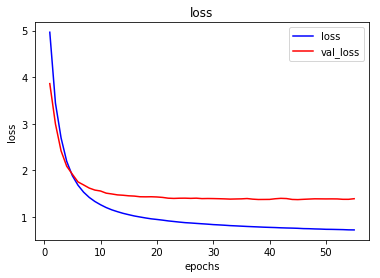

In [28]:
# loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='loss')
plt.plot(epochs, val_loss, 'r', label='val_loss')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [10]:
# bleu评分

n=6000    # 参与评分的样本个数

inputs=input_texts[num_train+1:num_train+n+1]
targets=target_texts[num_train+1:num_train+n+1]

input_seqs=[]
for input_text in inputs:
    input_seqs.append(text2seq(input_text, input_token_index, encoder_max_len, isdt=False))

decoded = decode(model,
                 input_seqs,
                 start_token=target_token_index['\t'],
                 end_token=target_token_index['\n'],
                 pad_token=target_token_index[' '])

bleu_score1 = []
bleu_score2 = []
bleu_score3 = []
bleu_score4 = []
for i in range(0,n-1):
    output = ' '.join(map(lambda x: target_index_token[x], decoded[i][1:-1]))
    output = output.strip()
    print('输入：'+inputs[i])
    print('预测：'+output)
    target = targets[i]
    print('目标：'+target)
    print()
    bleu_score1.append(sentence_bleu([target.split()],output.split(),weights=(1, 0, 0, 0)))
    bleu_score2.append(sentence_bleu([target.split()],output.split(),weights=(0, 1, 0, 0)))
    bleu_score3.append(sentence_bleu([target.split()],output.split(),weights=(0, 0, 1, 0)))
    bleu_score4.append(sentence_bleu([target.split()],output.split(),weights=(0, 0, 0, 1)))
    
print("score1 = {}".format(sum(bleu_score1)/len(bleu_score1)))
print("score2 = {}".format(sum(bleu_score2)/len(bleu_score2)))
print("score3 = {}".format(sum(bleu_score3)/len(bleu_score3)))
print("score4 = {}".format(sum(bleu_score4)/len(bleu_score4)))

输入：i think you should get it
预测：je pense que tu devrais le rendre
目标：je pense que vous devriez l'obtenir



D:\PythonTools\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\PythonTools\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\PythonTools\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


输入：it was sunny yesterday
预测：il faisait du soleil hier
目标：le temps était ensoleillé hier

输入：i have a great deal to do tonight
预测：j'ai un grand compte ce soir
目标：j'ai beaucoup de choses à faire ce soir

输入：they're so funny
预测：ils sont tellement drôles
目标：ils sont si drôles

输入：i never had to worry about money
预测：je n'ai jamais eu de souci à s'inquiéter
目标：je n'ai jamais eu à m'en faire pour l'argent

输入：i don't think that's possible
预测：je ne pense pas que c'est possible
目标：je ne pense pas cela possible

输入：i'm not wealthy
预测：je ne suis pas riche
目标：je ne suis pas riche

输入：let's get something to eat
预测：allons prendre quelque chose à manger
目标：allons prendre quelque chose à manger

输入：i'm still in love with mary
预测：je suis toujours amoureux de mary
目标：je suis toujours amoureuse de mary

输入：take your hat off when you enter a house of worship
预测：ôtez votre couvre-chef lorsque tu pénétrez dans un lieu de culte
目标：ôtez votre couvre-chef lorsque vous pénétrez dans un lieu de culte

输入：tom ta

输入：i hope that she listens to me
预测：j'espère qu'elle m'écoute
目标：j'espère qu'elle m'écoute

输入：where is this train going
预测：où est ce train
目标：où va ce train

输入：tom should do what mary says
预测：tom devrait faire ce que tom dit
目标：tom devrait faire ce que mary dit

输入：the whole town was in an uproar
预测：toute la ville était en effervescence
目标：toute la ville était en effervescence

输入：i know how you must be feeling
预测：je sais comment tu dois être mariée
目标：je sais comment tu dois te sentir

输入：let's check it out
预测：contrôlons-le
目标：contrôlons-la

输入：a little heavier rain might cause a flood
预测：une pluie a plus lourde succès à cause une crue
目标：une pluie un peu plus forte pourrait causer des inondations

输入：what have we gotten into
预测：qu'avons-nous rencontré
目标：dans quoi on s'est embarqué

输入：anybody wanna grab something to eat with me
预测：quiconque veut prendre quelque chose à manger avec moi
目标：quelqu'un veut-il aller chercher un truc à manger avec moi

输入：he's making progress
预测：il fait

输入：he went surfing
预测：il est allé faire un échec
目标：il est allé faire du surf

输入：can you read what's written on the blackboard
预测：peux-tu lire ce qui est écrit le tableau
目标：peux-tu lire ce qui est écrit au tableau

输入：i just want you to be happy
预测：je veux juste que tu sois heureuse
目标：je veux juste que tu sois heureux

输入：in my opinion you're wrong
预测：dans mon avis tu as tort
目标：à mon avis tu as tort

输入：when it comes to sweets i just can't control myself
预测：quand vient de sucreries je ne peux pas me contrôler
目标：pour les sucreries je ne sais pas me contrôler

输入：don't forget we have to do our homework
预测：n'oubliez pas que nous devons faire nos devoirs
目标：n'oubliez pas que nous devons faire nos devoirs

输入：get your gear
预测：allez chercher votre matériel
目标：va chercher tes affaires

输入：she is knitting a scarf
预测：elle tricote une écharpe
目标：elle tricote une écharpe

输入：we'll never let you down
预测：nous ne vous laisserons jamais tomber
目标：nous ne te laisserons jamais tomber

输入：for many 

输入：it seems like the cat caught the scent of a mouse
预测：il semble que le chat a fait l'odeur de la souris
目标：on dirait que le chat a détecté l'odeur d'une souris

输入：we haven't known each other very long
预测：nous ne connaissions pas depuis un autre temps
目标：nous ne nous connaissons pas depuis longtemps

输入：maybe there's a better way to do this
预测：peut-être il y a une meilleure manière de faire ça
目标：à mon avis il y a un meilleur moyen de faire ceci

输入：the talks will deal with the problem of pollution
预测：les pourparlers vont le problème de la pollution
目标：les discussions traiteront du problème de la pollution

输入：he cut the rope with his teeth
预测：il a coupé la corde avec ses dents
目标：il a coupé la corde avec ses dents

输入：please tell me where to park my car
预测：veuillez me dire où garer ma voiture
目标：merci de me dire où je dois garer ma voiture

输入：the ice gave way under his weight
预测：la glace atteignit son poids
目标：la glace a cédé sous son poids

输入：was that your idea
预测：était-ce votre 

输入：a selfish man thinks of nothing but his own feelings
预测：un homme égoïste pense de rien mais de ses propres sentiments
目标：un homme égoïste ne pense à rien sauf à ses propres sentiments

输入：do you have a mobile phone
预测：avez-vous un téléphone portable
目标：as-tu un portable

输入：what did you think of him
预测：qu'as-tu pensé de lui
目标：qu'as-tu pensé de lui

输入：get me out of here now
预测：sors-moi de ici maintenant
目标：sors-moi de là maintenant

输入：tom cleaned the bathroom
预测：tom nettoya la salle de bain
目标：tom nettoya la salle de bains

输入：i'll be grateful to you if you can do that for me
预测：je vous rendrai reconnaissant si tu peux faire ça pour moi
目标：je vous serais reconnaissant si vous pouviez faire ça pour moi

输入：you could've been hurt
预测：tu aurais pu être blessée
目标：vous auriez pu être blessée

输入：are you joking
预测：vous plaisantez
目标：tu plaisantes

输入：is there a bank near the station
预测：y a-t-il une banque près de la gare
目标：y a-t-il une banque proche de la gare

输入：i'd like to talk to o

输入：everyone wants something
预测：tout le monde veut quelque chose
目标：tout le monde veut quelque chose

输入：i'm finished with you
预测：j'ai fini avec toi
目标：j'en ai fini avec vous

输入：you never cease to amaze me
预测：tu ne cesses de m'impressionner
目标：tu ne cesses de m'émerveiller

输入：i think that tom may have a drinking problem
预测：je pense que tom peut avoir un problème
目标：je pense que tom a un problème avec l'alcool

输入：if i told you you wouldn't understand
预测：si je vous ai dit tu ne comprendrais pas
目标：si je te le disais tu ne comprendrais pas

输入：they made the right choice
预测：ils ont fait le droit de le choix
目标：ils ont fait le bon choix

输入：have you got something for me
预测：avez-vous eu quelque chose pour moi
目标：as-tu quelque chose pour moi

输入：when did you hear the sound
预测：quand avez-vous entendu le son son son de connaissance
目标：quand as-tu entendu le son

输入：you're very angry
预测：vous êtes très en colère
目标：tu es très en colère

输入：what song was tom singing
预测：quelle chanson tom chantai

预测：à qui est la voiture pour régler les cartes
目标：c'est à qui de distribuer

输入：i don't care what color ink just bring me a pen
预测：la couleur de quoi de pointe l'encre me convient
目标：la couleur m'est indifférente apporte-moi juste un stylo

输入：that student raised his hand to ask a question
预测：cet étudiant a levé la main à poser une question
目标：cet étudiant leva la main pour poser une question

输入：explain the fact as clearly as possible
预测：expliquez le fait aussi clair que possible
目标：expliquez les faits aussi clairement que possible

输入：when was the last explosion
预测：quand la dernière explosion
目标：à quand remonte la dernière explosion

输入：does that mean that we won
预测：cela signifie-t-il que nous avons gagné
目标：est-ce que ça signifie que nous avons gagné

输入：when i'm with you i'm happy
预测：quand je suis avec toi je suis heureux
目标：lorsque je suis avec toi je suis heureuse

输入：she recognized him immediately
预测：elle l'a reconnue immédiatement
目标：elle le reconnut immédiatement

输入：tom has j


输入：we've got a room for you
预测：nous avons une chambre pour toi
目标：nous avons une chambre pour vous

输入：what he's saying is actually true
预测：ce qu'il dit est factuel
目标：ce qu'il dit est en fait vrai

输入：my uncle comes back from america next monday
预测：mon oncle est de retour en amérique lundi prochain
目标：mon oncle revient d'amérique lundi prochain

输入：i know what it feels like
预测：je sais ce que c'est comme
目标：je sais ce que l'on ressent

输入：that is where you are wrong
预测：c'est là que tu as tort
目标：c'est là que tu commets une erreur

输入：there is an urgent need for blood donations
预测：il y a un besoin urgent de chopin sanguin
目标：il y a un besoin urgent de dons de sang

输入：we have a lot to do
预测：nous avons beaucoup à faire
目标：nous avons beaucoup à faire

输入：he who lives by the sword will die by the sword
预测：il vit jusqu'à l'épée en utilisant par l'épée
目标：celui qui vit par l'épée périra par l'épée

输入：the boys in the village laughed at me
预测：les garçons du village me sont moqués de moi
目标：l

输入：tom won't come today
预测：tom ne viendra pas aujourd'hui
目标：tom ne viendra pas aujourd'hui

输入：i know it's a lot of money
预测：je sais que c'est beaucoup d'argent
目标：je sais que c'est beaucoup d'argent

输入：our car ran out of gas after ten minutes
预测：notre voiture courut à court de augmentation après dix minutes
目标：notre voiture tomba en panne d'essence dix minutes plus tard

输入：anybody can participate
预测：qui que ce soit peut participer
目标：tout le monde peut participer

输入：why did you come here today
预测：pourquoi êtes-vous venus ici aujourd'hui
目标：pourquoi êtes-vous venues ici aujourd'hui

输入：what were you two talking about
预测：que êtes-vous parlé
目标：de quoi étiez-vous en train de parler toutes les deux

输入：you were sleeping weren't you
预测：tu étais au point de dormir n'est-ce pas
目标：tu étais en train de dormir n'est-ce pas

输入：is there room for me in your car
预测：y a-t-il de la place pour moi dans votre voiture
目标：est-ce qu'il y a de la place pour moi dans ta voiture

输入：i am worried about 

输入：she'd like him to leave right away
预测：elle aimerait qu'il y remette de droite
目标：elle aimerait qu'il parte séance tenante

输入：i amused myself
预测：je me suis amusé
目标：je me suis amusée

输入：could you draw a map for me
预测：pourriez-vous me tracer une carte
目标：pourrais-tu me tracer une carte

输入：i'll sue you
预测：je vous poursuivrai en justice
目标：je te poursuivrai en justice

输入：my mother cooks for me
预测：ma mère cuisine pour moi
目标：ma mère cuisine pour moi

输入：i owe you a lunch
预测：je te dois un déjeuner
目标：je vous dois un déjeuner

输入：i expected to see tom yesterday
预测：je m'attendais à voir tom hier
目标：je pensais voir tom hier

输入：i wonder where tom is
预测：je me demande où tom est
目标：je me demande où est tom

输入：i don't have any rooms for rent
预测：je n'ai aucune chambre de loyer
目标：je n'ai aucune chambre à louer

输入：it wasn't difficult to do that
预测：ce n'était pas difficile à faire ça
目标：ce n'était pas difficile de faire ça

输入：i'm not very organized
预测：je ne suis pas très organisée
目标：je ne 

输入：tell mary i love her
预测：dites à mary que je l'aime
目标：dis à mary que je l'aime

输入：we can't give up
预测：nous ne pouvons pas abandonner
目标：nous ne parvenons pas à arrêter

输入：i can't be seen with you
预测：je ne peux pas être vu avec toi
目标：je ne peux être vue en ta compagnie

输入：she stood transfixed as if she had seen a ghost
预测：elle se tenait la broue comme qu'elle avait vu un fantôme
目标：elle est restée figée comme si elle avait vu un fantôme

输入：he caught a boy stealing his watch
预测：il a attrapé un garçon qui a volé sa montre
目标：il attrapa un garçon en train de lui voler sa montre

输入：he ran as fast as he could
预测：il courut aussi vite qu'il pouvait
目标：il courut aussi vite qu'il pouvait

输入：stop following me
预测：arrête me suivez
目标：arrête de me suivre

输入：he has a huge ego
预测：il est le fait le nez
目标：il a un ego sur-dimensionné

输入：don't spread yourself too thin
预测：ne vous disperse pas trop
目标：n'en fais pas trop à la fois

输入：tom is a dreamer
预测：tom est rêveur
目标：tom est un rêveur

输入：a

输入：i don't know how to do that yet
预测：je ne sais pas encore comment faire ça
目标：je ne sais pas encore comment faire ça

输入：tokyo is a very expensive place to live
预测：tokyo est un endroit cher pour vivre
目标：tokyo est un lieu où la vie est très onéreuse

输入：does it hurt
预测：cela a-t-il mal
目标：est-ce que ça fait mal

输入：you can't win every time
预测：tu ne peux pas gagner chaque fois
目标：on ne peut pas gagner à chaque fois

输入：tom denied any guilt
预测：tom a nié toute culpabilité
目标：tom nia toute culpabilité

输入：you missed the meeting
预测：tu as manqué la réunion
目标：tu as loupé le meeting

输入：this reminds me of you
预测：ça me rappelle de toi
目标：ça me fait penser à vous

输入：he never seems to grow older
预测：il ne semble jamais pousser plus âgé
目标：il ne semble jamais vieillir

输入：i just hope it's not too late
预测：j'espère simplement que ce n'est pas trop en retard
目标：j'espère simplement qu'il n'est pas trop tard

输入：don't tell anyone what we're doing
预测：ne dites à personne ce que nous faisons
目标：ne dis à

输入：he cannot have said so
预测：il ne peut pas avoir dit ça
目标：il ne peut pas avoir dit cela

输入：correct the underlined words
预测：corrigez les mots soulignés
目标：corrige les mots soulignés

输入：we'll be there tomorrow afternoon
预测：nous y serons demain après-midi
目标：nous y serons demain après-midi

输入：how much do you feed your dog
预测：combien buvez-vous de manger ton chien
目标：quelle quantité de nourriture donnez-vous à manger à votre chien

输入：i thought tom was in school
预测：je pensais que tom était à l'école
目标：je pensais que tom était à l'école

输入：i've always thought you knew how to swim
预测：j'ai toujours pensé que tu savais nager
目标：j'ai toujours pensé que vous saviez nager

输入：sorry i didn't reply sooner
预测：désolé je n'ai pas répondu plus tôt
目标：désolée de ne pas avoir répondu plus tôt

输入：his proposal was worthless
预测：sa proposition n'a pas eu de valeur
目标：sa proposition n'avait pas la moindre valeur

输入：i need to find a restroom
预测：il me faut trouver des toilettes
目标：il me faut trouver de

输入：awesome
预测：génial
目标：fantastique

输入：i will give you this book
预测：je te donnerai ce livre
目标：je te donnerai ce livre

输入：i wonder how much time we've wasted so far
预测：je me demande combien de temps nous avons perdu à présent
目标：je me demande combien de temps nous avons gâché jusqu'à présent

输入：she has a new man in her life
预测：elle a un nouvel homme dans sa vie
目标：elle a un nouvel homme dans sa vie

输入：tom gave something to mary
预测：tom a donné quelque chose à mary
目标：tom a donné quelque chose à mary

输入：i think tom may be hurt
预测：je pense que tom peut être blessé
目标：je pense qu'il se peut que tom soit blessé

输入：when will you be back it all depends on the weather
预测：quand seras-tu de retour tout dépend de la météo
目标：quand seras-tu de retour tout dépend de la météo

输入：i wrote the note
预测：j'ai écrit la note
目标：j'ai écrit la note

输入：do you mind waiting for a minute
预测：est-ce que tu fais un moment de attendre une minute
目标：est-ce que cela vous dérange d'attendre une minute

输入：your m

输入：pay what you want
预测：paye ce que tu veux
目标：payez ce que vous voulez

输入：i didn't know tom
预测：je ne savais pas tom
目标：je ne connaissais pas tom

输入：replace it
预测：remplace-le
目标：remplacez-la

输入：do you think that tom will see me
预测：penses-tu que tom me verra
目标：penses-tu que tom me verra

输入：i've got a lot to tell
预测：j'ai beaucoup à dire
目标：j'ai beaucoup à dire

输入：you are no longer welcome here
预测：vous n'êtes plus le bienvenu ici
目标：tu n'es plus la bienvenue ici

输入：he is concerned about his parent's health
预测：il est préoccupé à sa santé de la santé
目标：il est inquiet pour la santé de ses parents

输入：we saw it
预测：nous l'avons vu
目标：nous l'avons vu

输入：are you listening to me
预测：m'écoutes-tu
目标：m'écoutez-vous

输入：how much money did you spend in total
预测：combien d'argent avez-vous claqué au total
目标：combien d'argent avez-vous dépensé au total

输入：i hired someone today
预测：j'ai engagé quelqu'un aujourd'hui
目标：j'ai engagé quelqu'un aujourd'hui

输入：would you mind coming earlier next time
预

输入：the baby in the cradle is very pretty
预测：le bébé dans le berceau est très mignon
目标：le bébé dans le berceau est très mignon

输入：there was a strong wind on that day
预测：il y avait un vent fort à ce jour-là
目标：il y avait un vent fort ce jour-là

输入：a dog followed me to my school
预测：un chien m'a suivi à ma école
目标：un chien m'a suivi jusqu'à l'école

输入：pickpockets target tourists
预测：les tire-laines ciblent les touristes
目标：les tire-laines ciblent les touristes

输入：are you sure you have the right address
预测：êtes-vous sûr d'avoir le bon adresse
目标：vous êtes sûr d'avoir la bonne adresse

输入：how dare you insult my sister
预测：comment oses-tu insulter ma sœur
目标：comment osez-vous insulter ma sœur

输入：tom didn't want mary to drive drunk
预测：tom ne voulait pas que mary coupe de panique
目标：tom ne voulait pas que marie conduise ivre

输入：i think you ought to rest a while
预测：je pense que vous devriez me reposer un moment
目标：je pense que tu devrais te reposer un moment

输入：she cooked some fish for me

预测：pourquoi avez-vous quitté l'australie
目标：pourquoi as-tu quitté l'australie

输入：i take a shower every morning
预测：je prends une douche chaque matin
目标：je prends une douche tous les matins

输入：you had better take her advice
预测：tu ferais mieux de prendre conseil
目标：tu ferais mieux de suivre son avis

输入：if it hadn't been for his help i'd have failed
预测：si on aurait été trouvé de son aide je aurais échoué
目标：s'il ne m'avait aidé j'aurais échoué

输入：are you at work
预测：êtes-vous au travail
目标：êtes-vous au travail

输入：you should get your hair cut
预测：tu devrais te déposer les cheveux
目标：tu devrais te couper les cheveux

输入：click on the link
预测：cliquez sur le lien
目标：cliquez sur le lien

输入：i want to be an astronaut
预测：je veux être un spationaute
目标：je veux être cosmonaute

输入：who hid my suspenders
预测：qui a caché mes bretelles
目标：qui a caché mes bretelles

输入：she woke up
预测：elle se réveilla
目标：elle se réveille

输入：there's nobody home
预测：il n'y a personne à la maison
目标：il n'y a personne chez 


输入：the school was established in 1650
预测：la école a été fondée en 1650
目标：cette école fut fondée en 1650

输入：are you sure that it was tom
预测：êtes-vous sûr que c'était tom
目标：êtes-vous sûr que c'était tom

输入：is there somebody you want to talk to
预测：y a-t-il quelqu'un que tu veuilles parler
目标：y a-t-il quelqu'un avec qui tu veuilles t'entretenir

输入：i don't think that that's necessary
预测：je ne pense pas que c'est nécessaire
目标：je ne pense pas que ce soit nécessaire

输入：what's your name
预测：comment s'appelle ton nom
目标：comment tu t'appelles

输入：this road goes to the park
预测：cette route va au parc
目标：cette route mène au parc

输入：you may choose whichever book you like
预测：tu peux choisir celui qui te plaît
目标：tu peux choisir n'importe quel livre que tu aimes

输入：why did you decide to do that
预测：pourquoi as-tu décidé de faire ça
目标：pourquoi avez-vous décidé de faire cela

输入：i did a good job
预测：j'ai fait un bon travail
目标：j'ai fait du bon travail

输入：who was this picture painted by
预测：qui a 

目标：elle tenta de le persuader d'aller avec elle

输入：the weather is terrible
预测：le temps est horriblement malade
目标：le temps est horrible

输入：you know we'd never hurt you
预测：tu sais que nous ne nous ferions jamais de mal
目标：vous savez que nous ne vous ferions jamais de mal

输入：this hat is too small please show me another one
预测：ce chapeau est trop petit je me prie de me montrer un autre
目标：ce chapeau est trop petit apportez-m'en un autre s'il vous plaît

输入：am i making myself clear
预测：suis-je en train de me faire claire
目标：me fais-je bien comprendre

输入：i'm the captain of this ship
预测：je suis le capitaine de ce navire
目标：je suis le capitaine de ce bateau

输入：shake hands with tom
预测：serre de tom
目标：serre la main de tom

输入：if you do it this way you can save several hours
预测：si tu le fais pour cette façon tu peux gagner plusieurs heures
目标：si tu le fais de cette façon tu peux gagner plusieurs heures

输入：that explains it
预测：ça l'explique
目标：ça l'explique

输入：a cop was killed
预测：un policier

预测：bien sûr
目标：pardi

输入：i was beaten
预测：j'ai été frappée
目标：j'ai été frappée

输入：i think this is mine
预测：je pense que c'est à moi
目标：je pense que c'est la mienne

输入：i want them alive
预测：je les veux vivant
目标：je les veux vivants

输入：if you need a ride i could come and get you
预测：si tu as besoin d'être en train de monter je pouvais venir
目标：si tu as besoin de te faire conduire je pourrais venir te chercher

输入：stay in bed
预测：restez alitée
目标：reste au lit

输入：please handle it with the utmost care
预测：s'il te plaît traite avec le plus grand soin
目标：je te prie de la manipuler avec le plus grand soin

输入：japan has become a powerful nation
预测：le japon est devenu une nation puissante
目标：le japon est devenu une nation puissante

输入：we're going to see tom again
预测：nous allons revoir tom
目标：nous allons revoir tom

输入：if i were you i wouldn't do such a thing
预测：si j'étais vous je ne ferais pas une telle chose
目标：si j'étais toi je ne ferais pas une telle chose

输入：i think you mentioned that last w

输入：tom won't likely be mistaken
预测：tom ne se frappera
目标：tom ne se trompera probablement pas

输入：you said i was beautiful
预测：tu as dit que j'étais belle
目标：tu as dit que j'étais belle

输入：do it again
预测：refaites-le
目标：refaites-le

输入：i think we should stick to the original plan
预测：je pense que nous devrions en tenir au projet initial
目标：je pense qu'on devrait s'en tenir au plan initial

输入：may i go
预测：puis-je y aller
目标：puis-je y aller

输入：i'd like to dance
预测：j'aimerais danser
目标：j'aimerais danser

输入：that's all you ever say
预测：c'est tout ce que tu dis
目标：c'est tout ce que tu dis toujours

输入：can i use my credit card
预测：puis-je utiliser ma carte de crédit
目标：puis-je utiliser ma carte de crédit

输入：i rechecked the data
预测：j'ai de nouveau vérifié les données
目标：j'ai de nouveau vérifié les données

输入：i already did it
预测：je l'ai déjà fait
目标：je l'ai déjà fait

输入：i don't know what else i could've done
预测：je ne sais pas ce que j'aurais pu faire
目标：je ne sais pas ce que j'aurais pu faire d

目标：a vrai dire je n'aime pas ce que tu portes

输入：i was the only one not invited to the party
预测：j'ai été le seul à ne pas être invité à la fête
目标：j'ai été la seule à ne pas être invitée à la fête

输入：where's my sister
预测：où est ma sœur
目标：où est ma sœur

输入：that's his
预测：c'est ça
目标：c'est le sien

输入：we had lunch at noon
预测：nous avons déjeuné à midi
目标：nous avons déjeuné à midi

输入：a man came in and sat on the stool next to her
预测：un homme est venu et assis dans le tabouret au fonction de son prochain secours
目标：un homme entra et s'assit sur un tabouret à côté d'elle

输入：i don't want a big wedding
预测：je ne veux pas de gros mariage
目标：je ne veux pas d'un grand mariage

输入：tom drank milk
预测：tom a bu du lait
目标：tom a bu du lait

输入：did you go to the restaurant yesterday
预测：êtes-vous allées au restaurant hier
目标：est-ce que vous êtes allée au restaurant hier

输入：i'll go to the hospital
预测：j'irai à l'hôpital
目标：j'irai à l'hôpital

输入：how much are the pears
预测：combien coûtent les poires
目标：

预测：nous étions tous préoccupés
目标：nous nous faisions toutes du souci

输入：so what do you say
预测：alors est-ce que tu dis
目标：alors qu'en dites-vous

输入：we got separated
预测：nous avons été séparées
目标：nous nous sommes séparées

输入：a stone does not float
预测：une pierre ne te conviendrait-il pas
目标：une pierre ne flotte pas

输入：my father allowed me to go swimming
预测：mon père m'a permis de nager
目标：mon père m'a laissé aller nager

输入：i hope i didn't make you feel uncomfortable
预测：j'espère que je ne vous ai pas fait mal de l'aise
目标：j'espère que je ne t'ai pas mise mal à l'aise

输入：don't you have an interesting face
预测：n'as-tu pas un visage intéressant
目标：n'avez-vous pas un visage intéressant

输入：avoid it at all cost
预测：évite-le à tout prix
目标：évite-la à tout prix

输入：hang on we'll be right there
预测：viens que nous y serons raison
目标：tiens bon nous arrivons

输入：you both want the same thing right
预测：tu veux tous les deux la même chose n'est-ce pas
目标：vous souhaitez tous les deux la même chose non



输入：i'll be free next sunday
预测：je serai libre dimanche prochain
目标：je serai libre dimanche prochain

输入：the whole family was sick in bed
预测：toute famille était malade au lit
目标：toute la famille était malade au lit

输入：mary has her problems
预测：mary a ses problèmes
目标：marie a ses propres problèmes

输入：you're perfect for me
预测：vous êtes parfaites pour moi
目标：tu es parfait pour moi

输入：do you have a mobile phone
预测：avez-vous un téléphone portable
目标：avez-vous un natel

输入：you gotta get more organized
预测：il vous faut être plus organisé
目标：il vous faut être davantage organisées

输入：it's very cloudy i think it's going to rain
预测：c'est très nuageux je pense qu'il se pleuve
目标：le temps est très nuageux je crois qu'il va pleuvoir

输入：i just want to say that i believe you
预测：je veux juste dire que je vous crois
目标：je veux simplement dire que je vous crois

输入：don't take me for granted
预测：ne me prends pas pour acquis
目标：ne me prends pas pour acquis

输入：what are your weekend plans
预测：quels sont vos


输入：she wrote to him to tell him that she loved him
预测：elle lui a écrit pour lui dire qu'elle l'aimait
目标：elle lui écrivit pour lui dire qu'elle l'aimait

输入：i'll see you tomorrow at school
预测：je te verrai demain à l'école
目标：je te verrai demain à l'école

输入：father is going to undergo an operation
预测：père va subir une opération
目标：père va subir une opération

输入：the leaves of the trees began to turn red
预测：les feuilles de vente pour les arbres se mit à tourner au rouge
目标：les feuilles des arbres commencèrent à devenir rouges

输入：don't try to blame this all on me
预测：n'essayez pas de me reprocher tout le visage
目标：n'essayez pas de me mettre tout ça sur le dos

输入：my native language is french
预测：ma langue maternelle est le français
目标：ma langue maternelle est le français

输入：would you sing for me
预测：voulez-vous chanter pour moi
目标：chanterais-tu pour moi

输入：i didn't mean to challenge your authority
预测：je n'avais pas l'intention de quitter ton autorité
目标：je ne voulais pas remettre en cau

目标：je n'ai pas ma place ici

输入：i don't think i've slept enough
预测：je ne pense pas que je dorme assez
目标：je ne crois pas avoir assez dormi

输入：january is usually the coldest month
预测：janvier est habituellement le mois le plus rapide de plus clair
目标：janvier est normalement le mois le plus froid

输入：my cat rubbed her head against my shoulder
预测：mon chat se frotta la tête contre mon épaule
目标：mon chat frotta sa tête contre mon épaule

输入：i will badly miss you if you leave japan
预测：tu me manqueras profondément si tu partes le japon
目标：vous me manquerez terriblement si vous quittez le japon

输入：i'm so happy to meet you
预测：je suis tellement heureux de te rencontrer
目标：je suis si heureux de te rencontrer

输入：i cry every day
预测：je pleure chaque jour
目标：je pleure chaque jour

输入：he is dreaming of becoming an astronaut
预测：il est en train de vendre d'un spationaute
目标：il rêve de devenir astronaute

输入：don't do it
预测：ne le faites pas
目标：ne le faites pas

输入：the taxi picked up two passengers
预测：le

预测：elles semblent tous deux suspects
目标：elles semblent toutes deux suspicieuses

输入：they have plenty of money
预测：ils ont plein d'argent
目标：elles disposent de plein d'argent

输入：don't underestimate your own strength
预测：ne sous-estimez pas ta propre force
目标：ne sous-estime pas ta propre force

输入：i know tom has been sick
预测：je sais que tom est malade
目标：je sais que tom a été malade

输入：i want to show you something in the office
预测：je veux te montrer quelque chose dans le bureau
目标：je veux te montrer quelque chose dans le bureau

输入：i don't know how to thank you
预测：je ne sais pas comment vous remercier
目标：je ne sais comment vous remercier

输入：my sister doesn't have a car
预测：ma sœur n'a pas une voiture
目标：ma sœur n'a pas de voiture

输入：i believe that
预测：je crois ça
目标：j'y crois

输入：we have to acknowledge that
预测：nous devons l'admettre
目标：nous devons l'admettre

输入：i'm very lonely here
预测：je suis très seul ici
目标：je suis très seul ici

输入：i thought you were injured
预测：je pensais que tu étai

输入：we have to make sure we have enough volunteers
预测：nous devons m'assurer que nous avons assez volontaire
目标：nous devons nous assurer que nous avons assez de bénévoles

输入：the peace talks failed once again
预测：la paix parle souffre à nouveau
目标：les pourparlers de paix ont de nouveau échoué

输入：i don't think that i deserve this
预测：je ne pense pas que je mérite ça
目标：je ne pense pas que je le mérite

输入：that's why i'm here
预测：c'est pourquoi je suis ici
目标：c'est pour ça que je suis là

输入：this piece of music is way too difficult for me to play
预测：ce morceau de musique est trop difficile à jouer
目标：ce morceau de musique est bien trop difficile à jouer pour moi

输入：i am the first musician in my family
预测：je suis le premier musicien de ma famille
目标：je suis le premier musicien de la famille

输入：he wouldn't harm a fly
预测：il ne ferait pas de mal à faire
目标：il ne ferait pas de mal à une mouche

输入：thanks to all of you
预测：merci de toutes
目标：merci à vous toutes

输入：i'm sorry but i can't put it in

目标：n'achète pas ça

输入：he tried to make his wife happy but he couldn't
预测：il a essayé de faire sa femme heureux mais il ne pouvait pas
目标：il a essayé de rendre sa femme heureuse mais il n'y est pas parvenu

输入：tom had never hit me before
预测：tom ne m'a jamais frappé auparavant
目标：tom ne m'avait jamais frappé avant

输入：do you have any kind of alibi
预测：avez-vous un genre d'orange
目标：avez-vous le moindre alibi

输入：she gave an oral report to her boss
预测：elle fit un compte-rendu oral à son patron
目标：elle rendit un rapport oral à son patron

输入：what do you think happens then
预测：que pensez-vous qu'il advienne
目标：que pensez-vous alors qu'il se produise

输入：the kids are driving me crazy
预测：les enfants me rendent avec moi folles
目标：les enfants me rendent dingue

输入：all families with children get special rates
预测：toutes les familles avec des enfants bénéficient de prix réduits de prix
目标：toutes les familles avec des enfants bénéficient de prix réduits

输入：why won't anyone talk about this
预测：pourqu

预测：j'ai vérifié partout
目标：j'ai vérifié partout

输入：the two of them split up
预测：les deux se sont séparés
目标：les deux se séparèrent

输入：i want a lawyer
预测：je veux un avocat
目标：je veux un avocat

输入：would you lend me some money
预测：me prêteriez-vous de l'argent
目标：me prêterais-tu de l'argent

输入：would you carry this up to the second floor for me
预测：voudrais-tu faire cette deuxième étage pour moi
目标：voudriez-vous me monter ceci au premier étage

输入：we didn't recognize each other
预测：nous ne nous avons pas reconnue
目标：on ne s'est pas reconnus

输入：don't you want some ice cream
预测：ne voulez-vous pas de glace
目标：ne voulez-vous pas de glace

输入：keep your hands still
预测：garde les mains
目标：ne bouge pas les mains

输入：hello how's business
预测：salut comment se déroule
目标：salut comment marche ton affaire

输入：it's a big concern
预测：c'est une grande préoccupation
目标：c'est une grande préoccupation

输入：do we have time
预测：avons-nous le temps
目标：avons-nous le temps

输入：you must not eat too much
预测：vous ne dev

输入：do you want any of these flowers
预测：voulez-vous de ces fleurs
目标：veux-tu une de ces fleurs

输入：she never told me
预测：elle ne m'a jamais dit
目标：jamais elle ne me le dit

输入：i don't like you either
预测：je n'aime pas vous non plus
目标：je ne vous aime pas non plus

输入：i think he's an honest man
预测：je pense qu'il est un homme honnête
目标：je pense qu'il est honnête homme

输入：i'm sure tom will come tomorrow
预测：je suis sûr que tom viendra demain
目标：je suis sûre que tom viendra demain

输入：tom was your guitar teacher wasn't he
预测：tom était votre prof de guitare n'est-ce pas
目标：tom fut votre professeur de guitare n'est-ce pas

输入：when was the last time you wore boots
预测：quand as-tu porté des derniers temps que tu portes
目标：à quand remonte la dernière fois que tu as porté des bottes

输入：tom wasn't born rich
预测：tom n'est pas né riche
目标：tom n'est pas né riche

输入：i assume so
预测：je suppose si
目标：je le suppose

输入：there's food on the table
预测：il y a de la nourriture sur la table
目标：il y a de la nourri


输入：don't you see what you've become
预测：ne vois-tu pas ce que tu es devenu
目标：ne voyez-vous pas ce que vous êtes devenu

输入：i need to renew my id card
预测：je dois renouveler ma carte d'identité
目标：je dois faire renouveler ma carte d'identité

输入：i want you out of my office
预测：je veux que tu sortes de mon bureau
目标：je veux que vous sortiez de mon bureau

输入：tell me where to go next
预测：dis-moi où aller ensuite
目标：dites-moi où aller ensuite

输入：don't tell my wife
预测：ne dis pas ma femme
目标：ne dites rien à mon épouse

输入：it's just the two of us
预测：c'est précisément les deux
目标：ce n'est que nous deux

输入：i know i can do better
预测：je sais que je peux faire mieux
目标：je sais que je peux faire mieux

输入：if for some reason that should happen what would you do
预测：si pour une raison quelconque cela devrait arriver que ferais-tu
目标：si pour une raison quelconque cela devait avoir lieu que ferais-tu

输入：you can't control everything
预测：tu ne peux pas tout contrôler
目标：tu ne peux pas tout contrôler

输入：i

目标：tu rentres quand

输入：they're all thieves
预测：ce sont tous des voleurs
目标：ce sont tous des voleurs

输入：share your lunch with your brother
预测：partager ton planning avec ton frère
目标：partage ton déjeuner avec ton frère

输入：i believe you can help us
预测：je crois que tu peux nous aider
目标：je crois que tu peux nous aider

输入：i'm in love with you
预测：je suis amoureuse de toi
目标：je suis amoureux de vous

输入：i feel very cold
预测：je me sens très froid
目标：j'ai très froid

输入：do you have an english dictionary
预测：avez-vous un dictionnaire d'anglais
目标：est-ce que vous avez un dictionnaire d'anglais

输入：where are my socks
预测：où sont mes chaussettes
目标：où sont mes chaussettes

输入：where would you like to live
预测：où aimerais-tu vivre
目标：où aimeriez-vous vivre

输入：sickness prevented him from going out
预测：le mal l'avertit de sortir
目标：il n'a pas pu sortir à cause de la maladie

输入：my room has a large closet
预测：ma chambre a une grande armoire
目标：dans ma chambre il y a une grande armoire

输入：he's a bit naive

预测：tom a passé la nuit seule
目标：tom a passé la nuit tout seul

输入：the nurse checked tom's pulse
预测：l'infirmière vérifia le pouls de tom
目标：l'infirmière vérifia le pouls de tom

输入：our visitors are sitting in the living room
预测：notre visiteurs sont assis dans la salle de vie
目标：nos visiteurs sont assis dans le salon

输入：neither is correct
预测：aucun n'est exact
目标：aucun n'est juste

输入：tie the horse to that tree
预测：noue le cheval à cet arbre
目标：attache le cheval à cet arbre

输入：what's the spiciest thing you've ever eaten
预测：quelle est la chose la plus épicée que tu aies jamais mangée
目标：quelle est la chose la plus épicée que tu aies jamais mangée

输入：do you mind opening the door
预测：est-ce que tu comprends la porte
目标：tu peux ouvrir la porte

输入：where did you find the keys
预测：où avez-vous trouvé les clés
目标：où as-tu trouvé les clés

输入：you finally succeeded in getting a job
预测：tu as finalement réussi à faire un travail
目标：vous avez finalement réussi à trouver un emploi

输入：we forgot to loc

输入：they attempted to assassinate the president
预测：ils ont tenté d'assassiner le président
目标：ils ont tenté d'assassiner le président

输入：i think you owe her an explanation
预测：je pense que tu dois une explication
目标：je pense que tu lui dois une explication

输入：tom turned off his computer
预测：tom a éteint son ordinateur
目标：tom a éteint son ordinateur

输入：your friends are waiting for you
预测：vos amis t'attendent
目标：tes amies t'attendent

输入：i'll make a copy for you
预测：je vais faire une copie pour toi
目标：je vous ferai une copie

输入：did i do something wrong
预测：ai-je fait quelque chose de travers
目标：ai-je fait quelque chose d'incorrect

输入：drink some water
预测：bois de l'eau
目标：buvez de l'eau

输入：sorry i didn't mean to interrupt
预测：désolé je n'avais pas l'intention de t'interrompre
目标：désolé je n'avais pas l'intention de t'interrompre

输入：look at that knight on the horse
预测：regarde ce chevalier sur le cheval
目标：regarde ce chevalier sur le cheval

输入：where did you grow up
预测：où t'es-tu grandi
目标：

目标：c'est étouffant ici je peux ouvrir une fenêtre

输入：he works too slowly to be helpful to us
预测：il travaille trop lentement pour nous être utile
目标：il travaille trop lentement pour nous être utile

输入：this color is a bit darker than that one
预测：cette couleur est un peu plus sombre que celui-là
目标：cette couleur est un peu plus sombre que celle-ci

输入：we spent the night in a cheap hotel
预测：nous avons passé la nuit dans un hôtel bon marché
目标：nous passâmes la nuit dans un hôtel bon marché

输入：do we have any more beer
预测：avons-nous de plus de bière
目标：est-ce qu'il nous reste de la bière

输入：what have you heard
预测：qu'as-tu entendu
目标：qu'avez-vous entendu

输入：your answer is right
预测：ta réponse est juste
目标：votre réponse est juste

输入：what's your name
预测：comment s'appelle ton nom
目标：quel est ton nom

输入：try to keep it down
预测：essaie de le garder
目标：essayez de ne pas vomir

输入：how did you find me
预测：comment m'avez-vous trouvé
目标：comment m'avez-vous trouvé

输入：your cat is fat
预测：votre chat est

预测：je préfère travailler épargne ses jetons
目标：je préfère travailler dans les coulisses

输入：the corpse has a gunshot wound in the chest
预测：le cadavre a une blessure par balle à la poitrine
目标：le cadavre montre une blessure par balle à la poitrine

输入：let's play by ourselves
预测：jouons toute seule
目标：jouons tous seuls

输入：the tv was on all the time
预测：la télévision était en temps à tout
目标：la télé était tout le temps allumée

输入：they were all smiling
预测：ils souriaient tous
目标：elles souriaient toutes

输入：i just want to go back to class
预测：je veux juste retourner à cours
目标：je veux juste retourner en classe

输入：there's a way to do it
预测：il y a une manière à le faire
目标：il y a une manière de le faire

输入：i want a refund
预测：je veux un remboursement
目标：je veux me faire rembourser

输入：i didn't know what to say to her
预测：je ne savais pas quoi lui dire
目标：je n'ai pas su que lui dire

输入：the garden is separated from the road by a fence
预测：le jardin est séparé de la voiture en voiture
目标：le jardin

输入：they won
预测：ils ont gagné
目标：elles gagnèrent

输入：tom imitated mary
预测：tom imita mary
目标：tom imita mary

输入：don't ignore her feelings
预测：ne ne parlez pas ses sentiments
目标：prenez en compte ses sentiments

输入：i got a lot of mosquito bites
预测：je me suis eu beaucoup de piqûres de moustiques
目标：j'ai été massivement piqué par les moustiques

输入：i know you've been busy
预测：je sais que vous êtes occupés
目标：je sais que vous avez été occupées

输入：when did you fire tom
预测：quand avez-vous éteint tom
目标：quand avez-vous renvoyé tom

输入：their houses are located near the sea
预测：leurs maisons se situent près de la mer
目标：leurs maisons se situent près de la mer

输入：could you tell me what's going on
预测：pourriez-vous me dire ce qui se passe
目标：pourriez-vous me dire ce qui est en train de se passer

输入：these are fresh
预测：ce sont bien frais
目标：ceux-ci sont frais

输入：what a lovely day
预测：quelle journée délicieuse
目标：quelle journée délicieuse

输入：i can't believe you're considering doing that
预测：je n'arrive 


输入：she was educated by her grandfather
预测：elle a été éduqué par son grand-père
目标：elle a été éduquée par son grand-père

输入：he offered his seat to an old woman
预测：il offrit son siège pour une femme agée
目标：il a offert sa place à une vieille dame

输入：it's our duty
预测：c'est notre devoir
目标：c'est notre devoir

输入：tom is john and mary's third child
预测：tom est john et le troisième enfant de mary
目标：tom est le troisième enfant de john et de mary

输入：i've just eaten so i'm not hungry
预测：j'ai simplement mangé je n'ai pas faim
目标：je viens de manger donc je n'ai pas faim

输入：the papers didn't print this story
预测：les journaux n'avaient pas cette histoire
目标：les journaux n'ont pas imprimé cette histoire

输入：i drink tea without sugar
预测：je bois du thé sans sucre
目标：je bois mon thé sans sucre

输入：tom is walking his dog
预测：tom marche au chien
目标：tom promène son chien

输入：you can do that right now
预测：tu peux faire ça maintenant
目标：tu peux faire cela maintenant

输入：i gave mary a book
预测：j'ai donné un 

目标：je n'avais pas le temps de me relaxer là-bas

输入：this course teaches basic skills in first aid
预测：ce qui loue les compétences les soldes de premier prix
目标：dans ce cours on apprend les connaissances de base en premier secours

输入：i didn't leave the door open
预测：je ne regardais pas la porte ouverte
目标：je n'ai pas laissé la porte ouverte

输入：i convinced everyone
预测：je suis convaincu tout le monde
目标：j'ai convaincu tout le monde

输入：i'm not saying this is your fault
预测：je ne dis pas que c'est de votre faute
目标：je ne dis pas que c'est de ta faute

输入：don't break my heart
预测：ne me cassez pas
目标：ne me brise pas le cœur

输入：i knew that tom was drunk
预测：je savais que tom était saoul
目标：je savais que tom était ivre

输入：do you have a bottle opener i could use
预测：avez-vous un décapsuleur à me prêter
目标：aurais-tu un décapsuleur à me prêter

输入：how often do you go shopping
预测：à quelle fréquence vas-tu faire des courses
目标：combien de fois vas-tu faire les courses

输入：i don't want cereal
预测：je ne 

预测：je veux te montrer quelque chose dans mon bureau
目标：je veux te montrer quelque chose dans mon bureau

输入：don't make me pull the trigger
预测：ne me forcez pas à tirer sur la gâchette
目标：ne me force pas à tirer sur la gâchette

输入：i still have to fix this
预测：j'ai toujours à réparer ça
目标：je dois toujours réparer ça

输入：if you had a time machine which year would you visit
预测：si tu disposais de temps de temps quelle année irais-tu
目标：si vous disposiez d'une machine à remonter le temps quelle année iriez-vous visiter

输入：a little bird told me
预测：un petit oiseau m'a dit
目标：un petit oiseau me l'a dit

输入：this is a big project
预测：c'est un gros projet
目标：c'est un gros projet

输入：i've said everything i was planning to say
预测：j'ai dit tout ce que j'avais prévu
目标：j'ai dit tout ce que je comptais dire

输入：how do you pronounce your name
预测：comment prononcez-vous ton nom
目标：comment faut-il prononcer votre prénom

输入：i'll leave it up to you
预测：je vous laisse vous lever
目标：je vous laisse la décision


输入：i appreciate this opportunity
预测：je me suis reconnaissant pour cette occasion
目标：j'apprécie cette opportunité

输入：i don't understand how this works
预测：je ne comprends pas comment ça fonctionne
目标：je ne comprends pas comment ça marche

输入：he went to america to study american literature
预测：il est allé en amérique d'étudier la littérature américaine
目标：il est allé en amérique pour étudier la littérature américaine

输入：how are you going to do that
预测：comment vas-tu faire ça
目标：comment vas-tu effectuer ça

输入：you will know the truth some day
预测：tu connaîtras la vérité de jour
目标：vous connaîtrez la vérité un jour

输入：i'm surprised that i don't have to do what you have to do
预测：je suis surpris de ne pas avoir à faire ce que tu as en faire
目标：je suis surpris de ne pas avoir à faire ce que vous vous avez

输入：she's two years younger than him
预测：elle est deux ans de plus jeune que lui
目标：elle a deux ans de moins que lui

输入：your paper contains too many mistakes
预测：ton journal contient trop d'e

目标：nous l'avons trouvé

输入：he dyed his hair black
预测：il s'est teint les cheveux noire
目标：il teignit ses cheveux en noir

输入：i can help you out
预测：je peux vous aider
目标：je peux te donner un coup de main

输入：tom says he wants a puppy for christmas
预测：tom dit qu'il veut un chiot pour noël
目标：tom dit qu'il veut un chiot pour noël

输入：pass me the salt and pepper please
预测：passez-moi le sel et le poivre s'il vous plaît
目标：passez-moi le sel et le poivre je vous prie

输入：do you really think it's no good
预测：pensez-vous vraiment que c'est pas bon
目标：pensez-vous vraiment que ce ne soit pas bon

输入：she doesn't speak japanese at home
预测：elle ne parle pas japonais à la maison
目标：elle ne parle pas japonais à la maison

输入：don't open the door for anybody
预测：n'ouvre la porte à personne
目标：n'ouvrez la porte à quiconque

输入：that's a good point
预测：c'est un bon argument
目标：c'est vrai

输入：the road curves gently towards the west
预测：la route courbe légèrement vers l'ouest
目标：la route vire légèrement vers l'ou

预测：que cherches-tu
目标：qu'est-ce que tu cherches

输入：don't buy me presents anymore
预测：ne m'achète plus de cadeaux
目标：ne m'achetez plus de cadeaux

输入：he wore a light blue tie
预测：il portait une cravate bleue
目标：il portait une cravate bleu clair

输入：we're fighting
预测：nous nous battons
目标：nous sommes en train de nous battre

输入：our teacher warned him not to be late again
预测：notre professeur l'avertit de ne pas être en plus en retard
目标：notre professeur l'avertit de ne plus être en retard

输入：please open the bottle
预测：ouvre la bouteille s'il te plait
目标：ouvrez la bouteille s'il vous plait

输入：can you will yourself to fall asleep
预测：peux-tu vous rendre endormie
目标：est-ce que tu peux te forcer à dormir

输入：she is really cute
预测：elle est vraiment mignon
目标：elle est vraiment mignonne

输入：she bought a new house the other day
预测：elle a acheté une nouvelle maison l'autre jour
目标：elle a acheté une nouvelle maison l'autre jour

输入：you owe me thirty bucks
预测：tu me dois de la confection de balles de p

输入：swimming is easy
预测：nager est facile
目标：nager c'est facile

输入：i'll start tomorrow
预测：je commencerai demain
目标：je commencerai demain

输入：i'm not cranky
预测：je ne suis pas grincheuse
目标：je ne suis pas grincheux

输入：be kind to little animals
预测：soyez gentils avec les animaux
目标：sois bon envers les petits animaux

输入：do you guys want to come too
预测：voulez-vous aussi venir
目标：est-ce que vous voulez aussi venir les gars

输入：i need to think of my children
预测：il me faut penser de mes enfants
目标：je dois penser à mes enfants

输入：it looks like tom is in love
预测：on dirait que tom est amoureux
目标：on dirait que tom est amoureux

输入：they survived even though the building was destroyed
预测：ils ont survécu même si l'immeuble a été détruit
目标：ce fut eux qui survécurent même si l'immeuble fut détruit

输入：we need to talk about it
预测：nous devons en parler
目标：nous devons en parler

输入：his sister looks young
预测：sa sœur a l'air jeune
目标：sa sœur a l'air jeune

输入：our troops engaged with the enemy
预测：nos trou


输入：why don't we take a little break
预测：pourquoi ne prenons-nous pas une petite pause
目标：pourquoi est-ce qu'on ne prendrait pas une petite pause

输入：hold your applause please
预测：retenez vos applaudissements je vous prie
目标：retenez vos applaudissements je vous prie

输入：tom was fired
预测：tom a été viré
目标：thomas a été licencié

输入：maybe tom was trying to warn us about something
预测：peut-être que tom essayait de nous avertir à propos de quelque chose
目标：peut-être tom essayait de nous avertir à propos de quelque chose

输入：i'd like to kiss mary
预测：j'aimerais embrasser mary
目标：j'aimerais embrasser mary

输入：anybody can do this
预测：n'importe qui peut faire ça
目标：n'importe qui peut faire ça

输入：what's your favorite drink in the summer
预测：quel est votre verre préférée dans l'été
目标：quelle est votre boisson préférée en été

输入：i'm old enough to make my own decisions
预测：je suis assez âgé pour me faire mes propres décisions
目标：je suis assez grand pour prendre mes propres décisions

输入：i'm not gonna li

# 预测

In [9]:
## 加载模型
model=load_model(save_path,custom_objects=get_custom_objects())

In [11]:
# #
texts=["I'm fine",
       "Thank you",
       "Let it go",
       "Excuse me",
       "Be careful",
       "How are you",
       "I eat a lot",
       "Give me that",
       "I don't know",    
       "Show yourself", 
       "You love dogs",
       "Please help me",
       "I am a student",
       "He is my brother",
       "I'm 19 years old",
       "Put your hands up",
       "I can't fight alone",
       "The weather is good",
       "This is the last time",
       "I'd like to have a cat",
       "She sleep all day today",
       "What are you waiting for",
       "Do you want to play a game",
       "Let's try to do this again",
       "There are 3 books on the desk",
       "I'm not ready for the final exam",
       "I have many problems in the study",
       ]


seqs=[]
for text in texts:
    text = clean(text)
    seqs.append(text2seq(text, input_token_index, encoder_max_len, isdt=False))
    
    
decoded = decode(
    model,
    seqs,
    start_token=target_token_index['\t'],
    end_token=target_token_index['\n'],
    pad_token=target_token_index[' '],
)

outputs=[]
for i in range(0,len(texts)):
    print(texts[i])
    outputs.append(' '.join(map(lambda x: target_index_token[x], decoded[i][1:-1])))
    print(outputs[i])
    print()


I'm fine
je vais bien

Thank you
merci

Let it go
laissez y aller

Excuse me
excuse-moi

Be careful
sois prudente

How are you
comment vas-tu

I eat a lot
je mange beaucoup

Give me that
donnez-moi ça

I don't know
je ne sais pas

Show yourself
montre-toi

You love dogs
tu aimes les chiens

Please help me
s'il te plait aide-moi

I am a student
je suis étudiant

He is my brother
c'est mon frère

I'm 19 years old
j'ai 19 ans

Put your hands up
mettez les mains

I can't fight alone
je ne peux pas me battre seul

The weather is good
le temps est bon

This is the last time
c'est le dernier

I'd like to have a cat
j'aimerais avoir un chat

She sleep all day today
elle dort toute la journée aujourd'hui

What are you waiting for
qu'est-ce que tu attends

Do you want to play a game
voulez-vous jouer un jeu

Let's try to do this again
essayons de le refaire

There are 3 books on the desk
il y a trois livres sur le bureau

I'm not ready for the final exam
je ne suis pas prêt pour le examen final
